## STATS-414 Final Evaludation
# Date: 2025-03-23

## Objectvie of this evaluation
# Synthetic minority augmented dataset:
#  - Baseline (100k)
#  - TVAE (100k) 
#  - CTGAN (100k)
#  - SMOTE (100k)
#  - TGGPT2 (1.8k)

In [1]:
# Synthetic Data Evaluation: Fidelity and Utility Testing

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial import distance
import os
import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pip install 'pandas<2,>=1.1.3'
%pip install 'scipy<2,>=1.11.0'
%pip install catboost
%pip install xgboost
%pip install tabpfn
%pip install 'numpy<2.0,>=1.16.0' # Update numpy
#%pip install --force-reinstall catboost # Force reinstall catboost after updating numpy to ensure binary compatibility

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# ML libraries
import xgboost as xgb
from catboost import CatBoost, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, mean_absolute_error, mean_squared_error,
                           r2_score, recall_score, precision_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
# Set aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Configure Pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [5]:
## 1. Data Loading and Exploration

def load_data(file_paths):
    """
    Load datasets from provided file paths

    Parameters:
    ----------
    file_paths : dict
        Dictionary with keys as dataset names and values as file paths

    Returns:
    --------
    datasets : dict
        Dictionary with keys as dataset names and values as pandas DataFrames
    """
    datasets = {}

    for name, path in file_paths.items():
        try:
            # Try different file formats
            if path.endswith('.csv'):
                datasets[name] = pd.read_csv(path)
            elif path.endswith('.parquet'):
                datasets[name] = pd.read_parquet(path)
            elif path.endswith('.h5'):
                datasets[name] = pd.read_hdf(path)
            elif path.endswith('.pkl') or path.endswith('.pickle'):
                datasets[name] = pd.read_pickle(path)
            elif path.endswith('.json'):
                datasets[name] = pd.read_json(path)
            else:
                print(f"Unsupported file format for {name}: {path}")
                continue

            print(f"Successfully loaded {name} dataset with shape {datasets[name].shape}")
        except Exception as e:
            print(f"Error loading {name} dataset: {e}")

    return datasets

# Specify file paths for all datasets
file_paths = {
    'original': '/Users/hochan.son/Project/MASDS/stats414/Data/New_Synthetic_datas/original_data_with_sample_100k.csv',  # Replace with actual file paths
    'tvae': '/Users/hochan.son/Project/MASDS/stats414/Data/New_Synthetic_datas/TVAE_synthetic_data.csv',
    'ctgan': '/Users/hochan.son/Project/MASDS/stats414/Data/New_Synthetic_datas/CTGAN_synthetic_data.csv',
    'smote': '/Users/hochan.son/Project/MASDS/stats414/Data/New_Synthetic_datas/smote_augmented.csv',
     'tggpt2': '/Users/hochan.son/Project/MASDS/stats414/Data/New_Synthetic_datas/tggpt2_synthetic_data.csv'
}

# Load all datasets
datasets = load_data(file_paths)

# Assign the datasets to specific variables for easier reference
original_df = datasets['original']
tvae_df = datasets['tvae']
ctgan_df = datasets['ctgan']
smote_df = datasets['smote']
tggpt2_df = datasets['tggpt2']

# Basic exploration of original dataset
print("\nOriginal dataset info:")
print(original_df.info())
print("\nSample of original data:")
print(original_df.head())

# Check for missing values in original dataset
print("\nMissing values in original dataset:")
print(original_df.isnull().sum())

# Determine target column (assuming it's labeled 'target' or 'label' or 'class')
potential_targets = ['target', 'label', 'class', 'y']
target_col = None

for col in potential_targets:
    if col in original_df.columns:
        target_col = col
        break

if target_col is None:
    print("\nCouldn't automatically detect target column. Please specify manually:")
    print(original_df.columns.tolist())
    # For this notebook, we'll assume 'target' exists
    target_col = 'target'

print(f"\nIdentified target column: {target_col}")

Successfully loaded original dataset with shape (100000, 35)
Successfully loaded tvae dataset with shape (1094226, 35)
Successfully loaded ctgan dataset with shape (100000, 35)
Successfully loaded smote dataset with shape (100000, 35)
Successfully loaded tggpt2 dataset with shape (1800, 35)

Original dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   log_id                100000 non-null  int64  
 1   label                 100000 non-null  int64  
 2   user_id               100000 non-null  int64  
 3   age                   100000 non-null  int64  
 4   gender                100000 non-null  int64  
 5   residence             100000 non-null  int64  
 6   city                  100000 non-null  int64  
 7   city_rank             100000 non-null  int64  
 8   series_dev            100000 non-null  int64  
 9


----- LABEL IMBALANCE ANALYSIS -----

Original dataset:
Binary classification detected
Majority class: 0 with 98431 samples
Minority class: 1 with 1569 samples
Imbalance ratio (majority:minority): 62.73:1


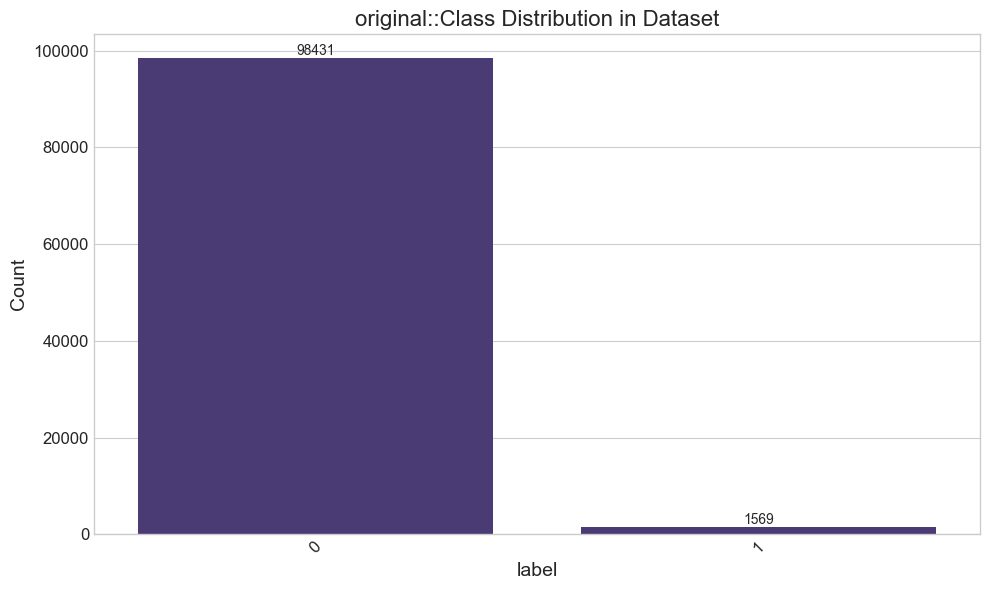


TVAE dataset:
Binary classification detected
Majority class: 0 with 982255 samples
Minority class: 1 with 111971 samples
Imbalance ratio (majority:minority): 8.77:1


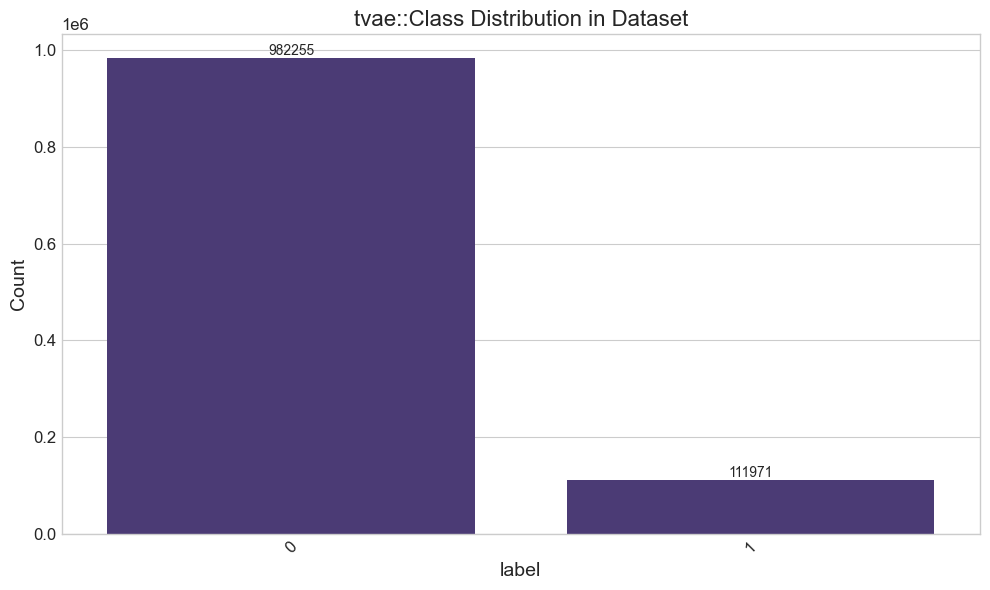


CTGAN dataset:
Binary classification detected
Majority class: 0 with 98431 samples
Minority class: 1 with 1569 samples
Imbalance ratio (majority:minority): 62.73:1


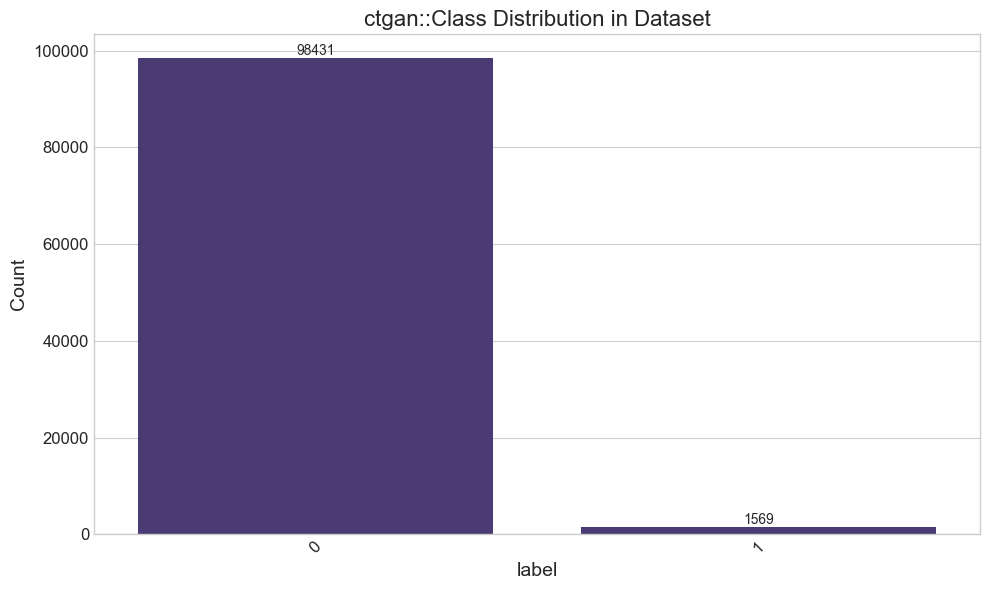


SMOTE dataset:
Binary classification detected
Majority class: 0 with 50037 samples
Minority class: 1 with 49963 samples
Imbalance ratio (majority:minority): 1.00:1


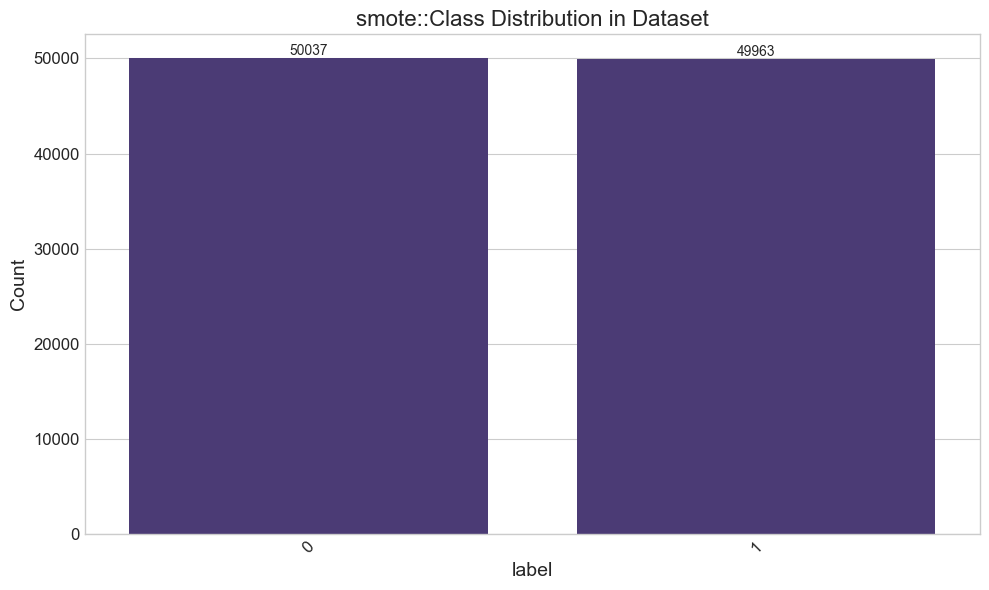


TGGPT2 dataset:
Binary classification detected
Majority class: 1 with 1677 samples
Minority class: 0 with 123 samples
Imbalance ratio (majority:minority): 13.63:1


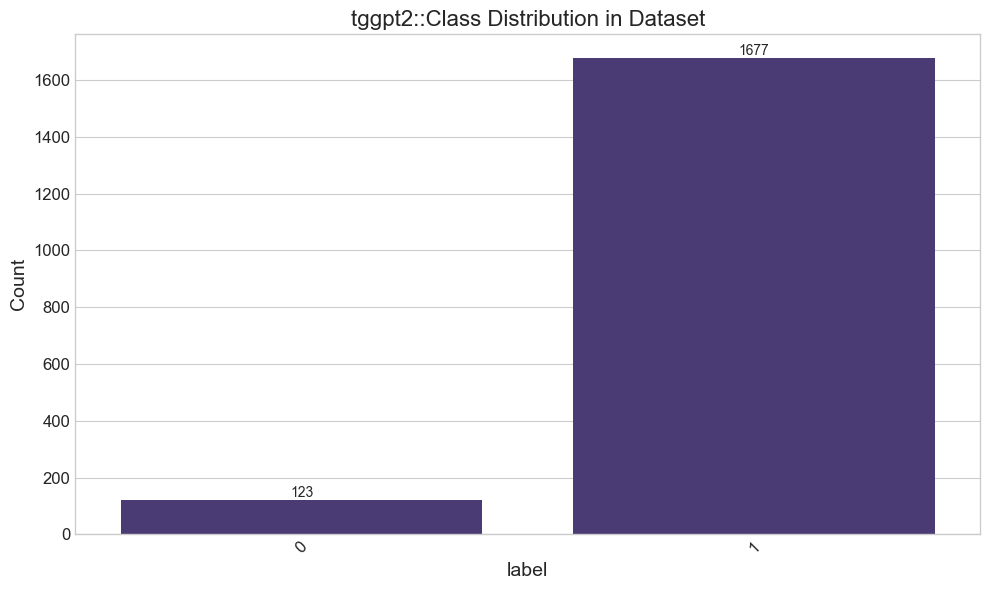

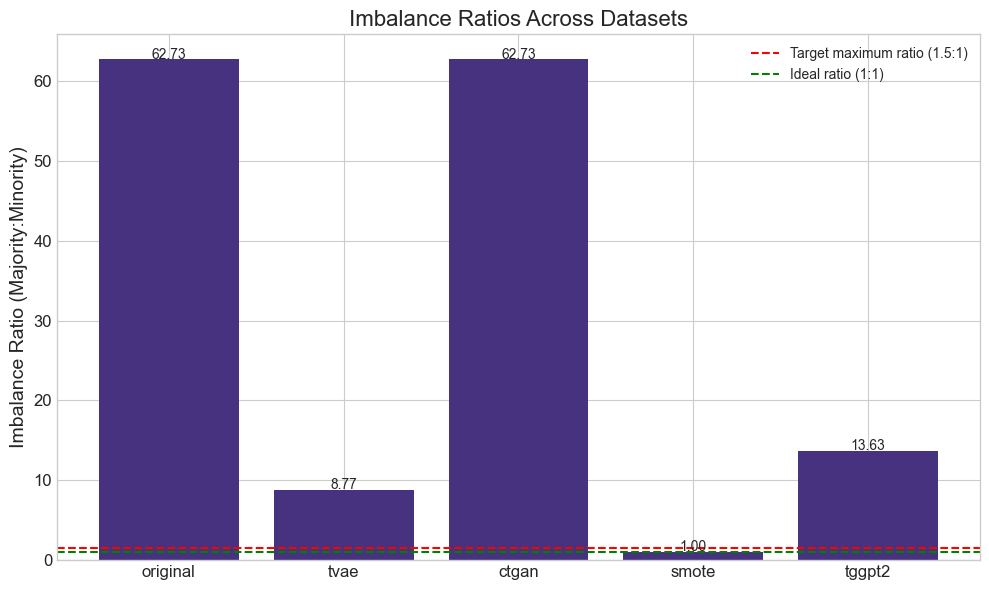

In [12]:

## 2. Label Imbalance Analysis

def analyze_label_imbalance(model_name, df, target_col):
    """
    Analyze the imbalance of labels in a dataset

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset to analyze
    target_col : str
        The name of the target column

    Returns:
    --------
    imbalance_ratio : float
        The ratio of majority to minority class
    class_counts : pandas Series
        The count of each class
    is_binary : bool
        Whether the target is binary
    """
    # Count the occurrences of each class
    class_counts = df[target_col].value_counts()

    # Determine if the target is binary
    is_binary = len(class_counts) == 2

    if is_binary:
        # Calculate imbalance ratio for binary classification
        majority_count = class_counts.max()
        minority_count = class_counts.min()
        imbalance_ratio = majority_count / minority_count
        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()

        print(f"Binary classification detected")
        print(f"Majority class: {majority_class} with {majority_count} samples")
        print(f"Minority class: {minority_class} with {minority_count} samples")
        print(f"Imbalance ratio (majority:minority): {imbalance_ratio:.2f}:1")
    else:
        # For multiclass, calculate the ratio of most common to least common
        max_count = class_counts.max()
        min_count = class_counts.min()
        imbalance_ratio = max_count / min_count

        print(f"Multiclass classification detected with {len(class_counts)} classes")
        print(f"Most common class has {max_count} samples")
        print(f"Least common class has {min_count} samples")
        print(f"Imbalance ratio (most:least common): {imbalance_ratio:.2f}:1")

        # Display distribution of all classes
        print("\nClass distribution:")
        for cls, count in class_counts.items():
            percentage = 100 * count / len(df)
            print(f"Class {cls}: {count} samples ({percentage:.2f}%)")

    # Visualize the class distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=target_col, data=df)

    # Add count labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom')

    plt.title(f'{model_name}::Class Distribution in Dataset')
    plt.xlabel(target_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return imbalance_ratio, class_counts, is_binary

# Analyze imbalance for all datasets
print("\n----- LABEL IMBALANCE ANALYSIS -----")
all_imbalance_data = {}

print("\nOriginal dataset:")
orig_imbalance, orig_class_counts, is_binary = analyze_label_imbalance('original',original_df, target_col)
all_imbalance_data['original'] = {'ratio': orig_imbalance, 'counts': orig_class_counts}

print("\nTVAE dataset:")
tvae_imbalance, tvae_class_counts, _ = analyze_label_imbalance('tvae',tvae_df, target_col)
all_imbalance_data['tvae'] = {'ratio': tvae_imbalance, 'counts': tvae_class_counts}

print("\nCTGAN dataset:")
ctgan_imbalance, ctgan_class_counts, _ = analyze_label_imbalance('ctgan',ctgan_df, target_col)
all_imbalance_data['ctgan'] = {'ratio': ctgan_imbalance, 'counts': ctgan_class_counts}

print("\nSMOTE dataset:")
smote_imbalance, smote_class_counts, _ = analyze_label_imbalance('smote',smote_df, target_col)
all_imbalance_data['smote'] = {'ratio': smote_imbalance, 'counts': smote_class_counts}

print("\nTGGPT2 dataset:")
tggpt2_imbalance, tggpt2_class_counts, _ = analyze_label_imbalance('tggpt2',tggpt2_df, target_col)
all_imbalance_data['tggpt2'] = {'ratio': tggpt2_imbalance, 'counts': tggpt2_class_counts}


# Compare imbalance ratios across datasets
imbalance_ratios = {name: data['ratio'] for name, data in all_imbalance_data.items()}

plt.figure(figsize=(10, 6))
bars = plt.bar(imbalance_ratios.keys(), imbalance_ratios.values())

# Add value labels on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{bar.get_height():.2f}', ha='center')

plt.axhline(y=1.5, color='r', linestyle='--', label='Target maximum ratio (1.5:1)')
plt.axhline(y=1.0, color='g', linestyle='--', label='Ideal ratio (1:1)')
plt.title('Imbalance Ratios Across Datasets')
plt.ylabel('Imbalance Ratio (Majority:Minority)')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:

## 3. Balancing the Synthetic Datasets

def balance_synthetic_dataset(synthetic_df, original_df, target_col, max_ratio=1.5, max_samples=200000):
    """
    Balance a synthetic dataset by adding samples from the original dataset
    to achieve a target imbalance ratio, with a maximum sample size

    Parameters:
    -----------
    synthetic_df : pandas DataFrame
        The synthetic dataset to balance
    original_df : pandas DataFrame
        The original dataset to draw additional samples from
    target_col : str
        The name of the target column
    max_ratio : float, default=1.5
        The maximum allowed imbalance ratio (majority:minority)
    max_samples : int, default=200000
        Maximum number of samples in the balanced dataset

    Returns:
    --------
    balanced_df : pandas DataFrame
        The balanced synthetic dataset
    """
    # Make a copy of the synthetic dataset
    balanced_df = synthetic_df.copy()

    # Get class counts in the synthetic dataset
    class_counts = balanced_df[target_col].value_counts()

    if len(class_counts) == 2:  # Binary classification
        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()
        majority_count = class_counts[majority_class]
        minority_count = class_counts[minority_class]

        # Calculate target minority count to achieve desired ratio
        target_minority_count = max(minority_count, int(majority_count / max_ratio))

        # If we need more minority samples
        if minority_count < target_minority_count:
            samples_needed = target_minority_count - minority_count
            print(f"Need {samples_needed} additional samples of class {minority_class}")

            # Get minority samples from original dataset
            original_minority_samples = original_df[original_df[target_col] == minority_class]

            # If we don't have enough samples in the original dataset, use what we have
            if len(original_minority_samples) < samples_needed:
                print(f"Not enough samples in original dataset. Using all {len(original_minority_samples)} available.")
                samples_to_add = original_minority_samples
            else:
                # Randomly sample the needed number of samples
                samples_to_add = original_minority_samples.sample(n=samples_needed, random_state=42)

            # Add the samples to the balanced dataset
            balanced_df = pd.concat([balanced_df, samples_to_add], ignore_index=True)

            print(f"Added {len(samples_to_add)} samples from original dataset")

    else:  # Multiclass classification
        # Get the count of the minority class
        min_class = class_counts.idxmin()
        min_count = class_counts[min_class]

        # For each class that needs boosting
        for cls, count in class_counts.items():
            # Calculate the target count based on the minimum class and max ratio
            target_count = max(count, int(min_count * max_ratio))

            # If we need more samples for this class
            if count < target_count:
                samples_needed = target_count - count
                print(f"Need {samples_needed} additional samples of class {cls}")

                # Get samples from original dataset
                original_class_samples = original_df[original_df[target_col] == cls]

                # If we don't have enough samples in the original dataset, use what we have
                if len(original_class_samples) < samples_needed:
                    print(f"Not enough samples in original dataset. Using all {len(original_class_samples)} available.")
                    samples_to_add = original_class_samples
                else:
                    # Randomly sample the needed number of samples
                    samples_to_add = original_class_samples.sample(n=samples_needed, random_state=42)

                # Add the samples to the balanced dataset
                balanced_df = pd.concat([balanced_df, samples_to_add], ignore_index=True)

                print(f"Added {len(samples_to_add)} samples from original dataset")

    # Ensure we don't exceed the maximum sample size
    if len(balanced_df) > max_samples:
        print(f"Dataset size ({len(balanced_df)}) exceeds maximum ({max_samples}). Downsampling...")

        # Stratified sampling to maintain class distribution
        balanced_df = balanced_df.groupby(target_col, group_keys=False).apply(
            lambda x: x.sample(int(max_samples * len(x) / len(balanced_df)), random_state=42)
        )

        print(f"Downsampled to {len(balanced_df)} samples")

    # Analyze the final class distribution
    final_class_counts = balanced_df[target_col].value_counts()
    majority_count = final_class_counts.max()
    minority_count = final_class_counts.min()
    final_ratio = majority_count / minority_count

    print(f"Final imbalance ratio: {final_ratio:.2f}:1")
    print(f"Final dataset size: {len(balanced_df)}")

    return balanced_df

# Balance all synthetic datasets
print("\n----- BALANCING SYNTHETIC DATASETS -----")
balanced_datasets = {}

print("\nBalancing TVAE dataset:")
balanced_tvae = balance_synthetic_dataset(tvae_df, original_df, target_col)
balanced_datasets['tvae'] = balanced_tvae

print("\nBalancing CTGAN dataset:")
balanced_ctgan = balance_synthetic_dataset(ctgan_df, original_df, target_col)
balanced_datasets['ctgan'] = balanced_ctgan

print("\nBalancing SMOTE dataset:")
balanced_smote = balance_synthetic_dataset(smote_df, original_df, target_col)
balanced_datasets['smote'] = balanced_smote

print("\nBalancing TGGPT2 dataset:")
balanced_tggpt2 = balance_synthetic_dataset(tggpt2_df, original_df, target_col)
balanced_datasets['tggpt2'] = balanced_tggpt2

# Verify final class distributions
for name, df in balanced_datasets.items():
    print(f"\nFinal class distribution for {name}:")
    class_counts = df[target_col].value_counts()
    for cls, count in class_counts.items():
        percentage = 100 * count / len(df)
        print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


----- BALANCING SYNTHETIC DATASETS -----

Balancing TVAE dataset:
Need 542865 additional samples of class 1
Not enough samples in original dataset. Using all 1569 available.
Added 1569 samples from original dataset
Dataset size (1095795) exceeds maximum (200000). Downsampling...
Downsampled to 199999 samples
Final imbalance ratio: 8.65:1
Final dataset size: 199999

Balancing CTGAN dataset:
Need 64051 additional samples of class 1
Not enough samples in original dataset. Using all 1569 available.
Added 1569 samples from original dataset
Final imbalance ratio: 31.37:1
Final dataset size: 101569

Balancing SMOTE dataset:
Final imbalance ratio: 1.00:1
Final dataset size: 100000

Balancing TGGPT2 dataset:
Need 995 additional samples of class 0
Added 995 samples from original dataset
Final imbalance ratio: 1.50:1
Final dataset size: 2795

Final class distribution for tvae:
Class 0: 179277 samples (89.64%)
Class 1: 20722 samples (10.36%)

Final class distribution for ctgan:
Class 0: 98431 sam


----- FIDELITY TESTING -----

Running fidelity tests for tvae:
  log_id: JS Divergence = 0.0623
  user_id: JS Divergence = 0.0833
  age: JS Divergence = 0.0150
  gender: JS Divergence = 0.0050
  residence: JS Divergence = 0.0618
  city: JS Divergence = 0.0727
  city_rank: JS Divergence = 0.0753
  series_dev: JS Divergence = 0.1237
  series_group: JS Divergence = 0.0623
  emui_dev: JS Divergence = 0.1151
  device_name: JS Divergence = 0.1034
  device_size: JS Divergence = 0.1079
  net_type: JS Divergence = 0.0780
  task_id: JS Divergence = 0.0917
  adv_id: JS Divergence = 0.0757
  creat_type_cd: JS Divergence = 0.0664
  adv_prim_id: JS Divergence = 0.0816
  inter_type_cd: JS Divergence = 0.0145
  slot_id: JS Divergence = 0.0633
  site_id: JS Divergence = 0.0000
  spread_app_id: JS Divergence = 0.0251
  hispace_app_tags: JS Divergence = 0.0791
  app_second_class: JS Divergence = 0.0473
  app_score: JS Divergence = 0.1416
  ad_click_list_v001: JS Divergence = 0.9973
  ad_click_list_v002:

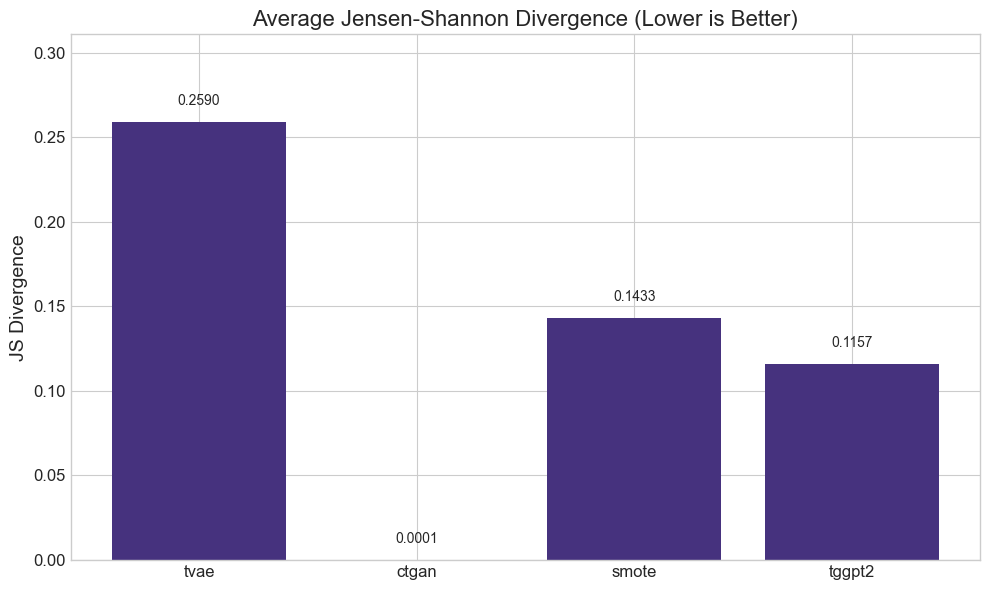

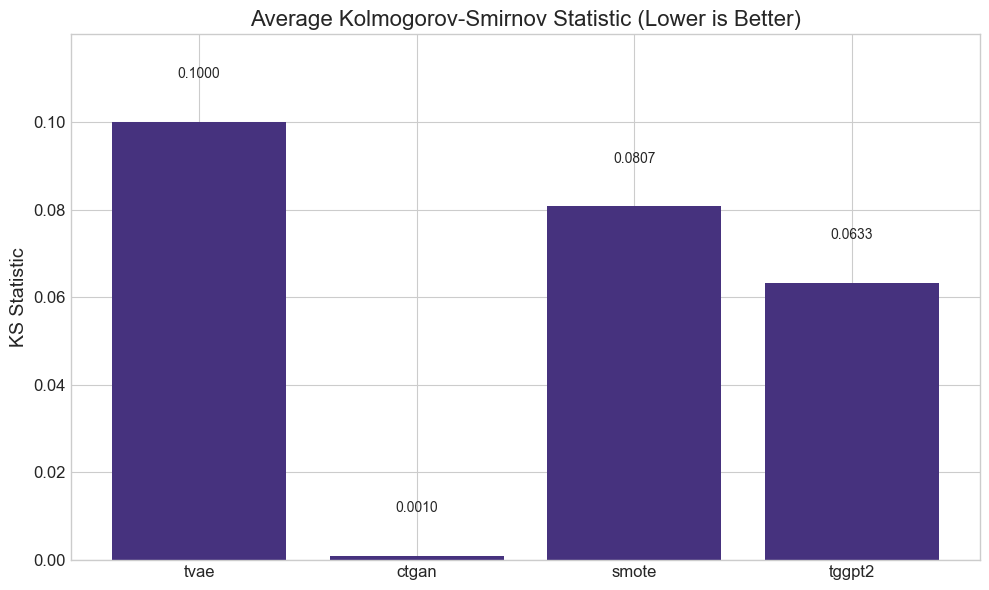

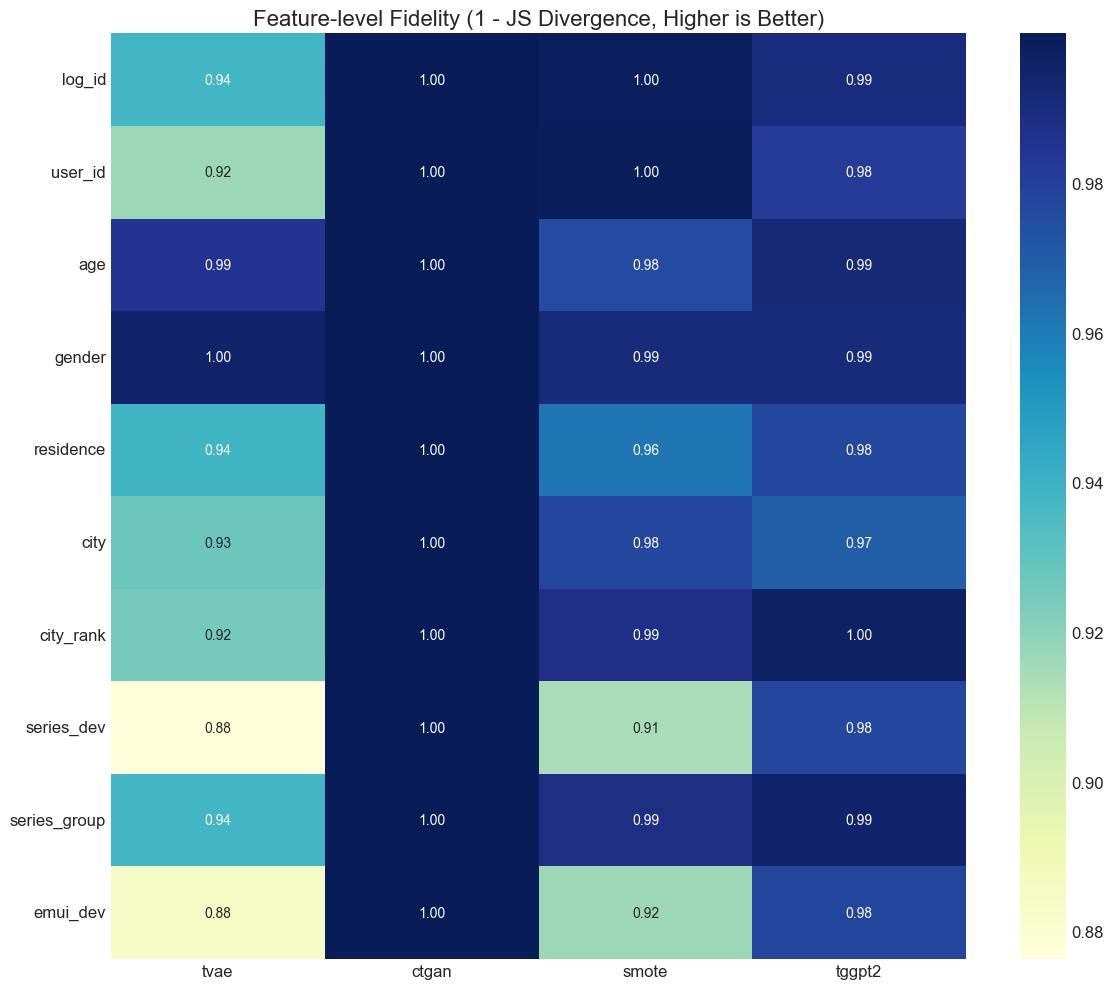

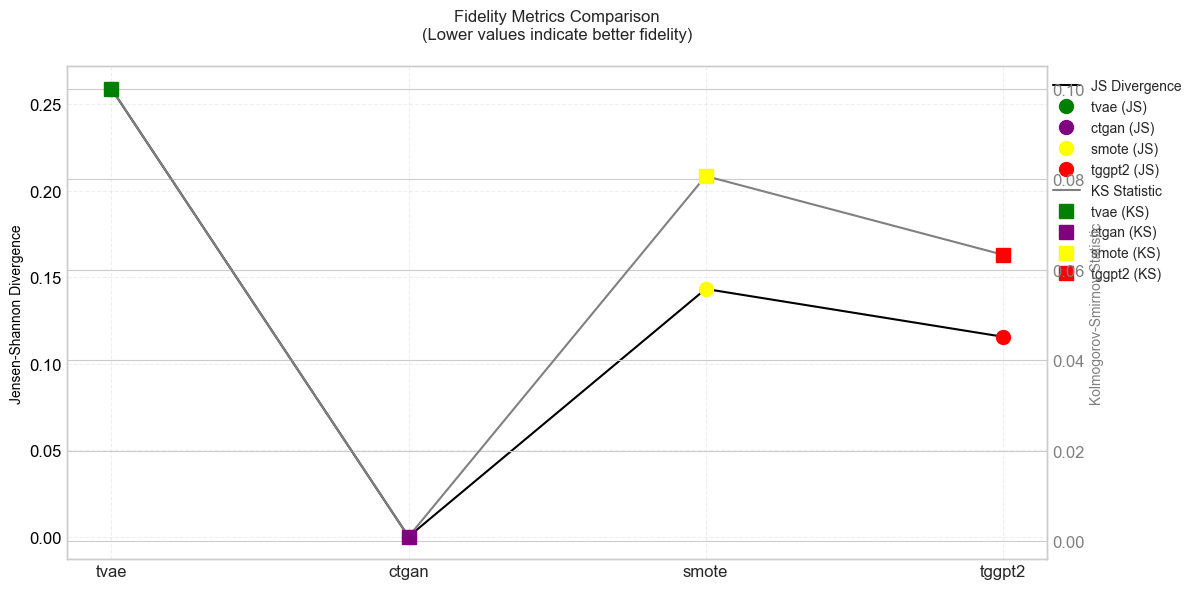

In [8]:

## 4. Fidelity Testing

def jensen_shannon_divergence(p, q):
    """
    Calculate the Jensen-Shannon divergence between two probability distributions

    Parameters:
    -----------
    p, q : array-like
        Probability distributions

    Returns:
    --------
    js_divergence : float
        Jensen-Shannon divergence
    """
    # Ensure the distributions sum to 1
    p = np.array(p)
    q = np.array(q)
    p = p / np.sum(p)
    q = q / np.sum(q)

    m = 0.5 * (p + q)

    # Calculate KL divergence for p and m, q and m
    kl_p_m = np.sum(p * np.log2(p / m, where=(p != 0)))
    kl_q_m = np.sum(q * np.log2(q / m, where=(q != 0)))

    # Jensen-Shannon divergence
    js_divergence = 0.5 * (kl_p_m + kl_q_m)

    return js_divergence

def calculate_column_divergence(original_df, synthetic_df, column):
    """
    Calculate the Jensen-Shannon divergence for a specific column

    Parameters:
    -----------
    original_df, synthetic_df : pandas DataFrame
        Original and synthetic datasets
    column : str
        Column name to calculate divergence for

    Returns:
    --------
    js_div : float
        Jensen-Shannon divergence for the column
    """
    # Convert columns to string if they contain mixed types
    if any(isinstance(x, (str, bytes)) for x in original_df[column].dropna()) or \
       any(isinstance(x, (str, bytes)) for x in synthetic_df[column].dropna()):
        orig_col = original_df[column].astype(str)
        synth_col = synthetic_df[column].astype(str)
        
        # Categorical feature
        orig_counts = orig_col.value_counts(normalize=True)
        synth_counts = synth_col.value_counts(normalize=True)

        # Ensure both distributions cover the same categories
        all_categories = sorted(set(orig_counts.index) | set(synth_counts.index))

        # Create arrays with counts for each category
        p = np.array([orig_counts.get(cat, 0) for cat in all_categories])
        q = np.array([synth_counts.get(cat, 0) for cat in all_categories])

        return jensen_shannon_divergence(p, q)
    else:
        # Numerical feature
        # Use histogram bins for probability distributions
        hist_bins = 50  # Number of bins for histogram

        # Get min and max values from both datasets
        min_val = min(original_df[column].min(), synthetic_df[column].min())
        max_val = max(original_df[column].max(), synthetic_df[column].max())

        # Create histograms
        hist_orig, bin_edges = np.histogram(original_df[column], bins=hist_bins,
                                          range=(min_val, max_val), density=True)
        hist_synth, _ = np.histogram(synthetic_df[column], bins=hist_bins,
                                    range=(min_val, max_val), density=True)

        # Calculate Jensen-Shannon divergence
        return jensen_shannon_divergence(hist_orig, hist_synth)

def run_ks_test(original_df, synthetic_df, column):
    """
    Run Kolmogorov-Smirnov test for a numerical column

    Parameters:
    -----------
    original_df, synthetic_df : pandas DataFrame
        Original and synthetic datasets
    column : str
        Column name to run KS test for

    Returns:
    --------
    ks_statistic : float or None
        KS test statistic
    p_value : float or None
        P-value from the KS test
    """
    # Check if column is numeric and has no mixed types
    try:
        if pd.api.types.is_numeric_dtype(original_df[column]) and pd.api.types.is_numeric_dtype(synthetic_df[column]):
            # Convert to float to ensure compatibility
            orig_values = original_df[column].astype(float)
            synth_values = synthetic_df[column].astype(float)
            
            # Remove any NaN values
            orig_values = orig_values.dropna()
            synth_values = synth_values.dropna()
            
            if len(orig_values) > 0 and len(synth_values) > 0:
                ks_statistic, p_value = stats.ks_2samp(orig_values, synth_values)
                return ks_statistic, p_value
    except:
        pass
    
    return None, None

def run_fidelity_tests(original_df, balanced_datasets):
    """
    Run fidelity tests (JL divergence, KS test) on balanced datasets

    Parameters:
    -----------
    original_df : pandas DataFrame
        The original dataset
    balanced_datasets : dict
        Dictionary of balanced synthetic datasets

    Returns:
    --------
    results : dict
        Dictionary of test results
    """
    results = {}

    # Get all columns except the target
    global all_columns
    all_columns = [col for col in original_df.columns if col != target_col]

    for dataset_name, synthetic_df in balanced_datasets.items():
        print(f"\nRunning fidelity tests for {dataset_name}:")

        # Initialize results for this dataset
        dataset_results = {
            'js_divergence': {},
            'ks_test': {},
            'average_js': 0.0,
            'average_ks': 0.0,
            'feature_fidelity': {}
        }

        # Calculate Jensen-Shannon divergence for each column
        js_values = []
        for column in all_columns:
            js_div = calculate_column_divergence(original_df, synthetic_df, column)
            dataset_results['js_divergence'][column] = js_div
            js_values.append(js_div)
            print(f"  {column}: JS Divergence = {js_div:.4f}")

        # Calculate average Jensen-Shannon divergence
        dataset_results['average_js'] = np.mean(js_values)
        print(f"  Average JS Divergence: {dataset_results['average_js']:.4f}")

        # Run KS test for numerical columns
        ks_values = []
        for column in all_columns:
            if original_df[column].dtype.name not in ['object', 'category', 'bool']:
                ks_statistic, p_value = run_ks_test(original_df, synthetic_df, column)
                if ks_statistic is not None:
                    dataset_results['ks_test'][column] = {'statistic': ks_statistic, 'p_value': p_value}
                    ks_values.append(ks_statistic)
                    print(f"  {column}: KS Statistic = {ks_statistic:.4f}, p-value = {p_value:.4f}")

        # Calculate average KS statistic (if any)
        if ks_values:
            dataset_results['average_ks'] = np.mean(ks_values)
            print(f"  Average KS Statistic: {dataset_results['average_ks']:.4f}")

        # Calculate feature fidelity (1 - JS Divergence)
        for column in all_columns:
            dataset_results['feature_fidelity'][column] = 1 - dataset_results['js_divergence'][column]

        results[dataset_name] = dataset_results

    return results

def plot_combined_fidelity_metrics(fidelity_results):
    """
    Create a combined plot for JS Divergence and KS Statistics with custom colors
    
    Parameters:
    -----------
    fidelity_results : dict
        Dictionary containing fidelity test results
    """
    # Define color scheme
    color_scheme = {
        'tvae': 'green',    # green
        'ctgan': 'purple',   # purple
        'smote': 'yellow',   # yellow
        'tggpt2': 'red'     # red
    }
    
    # Prepare data
    methods = list(fidelity_results.keys())
    js_values = [results['average_js'] for results in fidelity_results.values()]
    ks_values = [results['average_ks'] for results in fidelity_results.values()]
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    
    # Plot JS Divergence (dots connected by lines)
    line1 = ax1.plot(methods, js_values, 'o-', color='black', label='JS Divergence', 
                     linewidth=1.5, markersize=0, zorder=2)
    
    # Add colored dots for JS Divergence
    for i, method in enumerate(methods):
        ax1.plot(i, js_values[i], 'o', color=color_scheme[method], 
                markersize=10, label=f'{method} (JS)', zorder=3)
    
    # Plot KS Statistic (squares connected by lines)
    line2 = ax2.plot(methods, ks_values, 's-', color='gray', label='KS Statistic', 
                     linewidth=1.5, markersize=0, zorder=2)
    
    # Add colored squares for KS Statistic
    for i, method in enumerate(methods):
        ax2.plot(i, ks_values[i], 's', color=color_scheme[method], 
                markersize=10, label=f'{method} (KS)', zorder=3)
    
    # Customize axes
    ax1.set_ylabel('Jensen-Shannon Divergence', color='black', fontsize=10)
    ax2.set_ylabel('Kolmogorov-Smirnov Statistic', color='gray', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='gray')
    
    # Add grid
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, 
              loc='upper right', bbox_to_anchor=(1.15, 1))
    
    # Add title and adjust layout
    plt.title('Fidelity Metrics Comparison\n(Lower values indicate better fidelity)', 
             pad=20, fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# Run fidelity tests
print("\n----- FIDELITY TESTING -----")
fidelity_results = run_fidelity_tests(original_df, balanced_datasets)

# Visualize average Jensen-Shannon divergence
avg_js = {name: results['average_js'] for name, results in fidelity_results.items()}

plt.figure(figsize=(10, 6))
bars = plt.bar(avg_js.keys(), avg_js.values())

# Add value labels on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{bar.get_height():.4f}', ha='center')

plt.title('Average Jensen-Shannon Divergence (Lower is Better)')
plt.ylabel('JS Divergence')
plt.ylim(0, max(avg_js.values()) * 1.2)  # Add some space for the labels
plt.tight_layout()
plt.show()

# Visualize average KS statistic
avg_ks = {}
for name, results in fidelity_results.items():
    ks_values = [v['statistic'] for v in results['ks_test'].values() if v is not None]
    if ks_values:  # Only calculate average if there are valid KS statistics
        avg_ks[name] = np.mean(ks_values)

if avg_ks:  # Only create plot if there are valid KS statistics
    plt.figure(figsize=(10, 6))
    bars = plt.bar(avg_ks.keys(), avg_ks.values())

    # Add value labels on top of the bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{bar.get_height():.4f}', ha='center')

    plt.title('Average Kolmogorov-Smirnov Statistic (Lower is Better)')
    plt.ylabel('KS Statistic')
    plt.ylim(0, max(avg_ks.values()) * 1.2)  # Add some space for the labels
    plt.tight_layout()
    plt.show()
else:
    print("No valid KS statistics available for visualization")

# Visualize feature-level fidelity
# Select a subset of features to avoid overcrowding the plot
selected_features = all_columns[:10] if len(all_columns) > 10 else all_columns

# Prepare data for heatmap
heatmap_data = np.zeros((len(selected_features), len(fidelity_results)))
for i, feature in enumerate(selected_features):
    for j, (dataset_name, results) in enumerate(fidelity_results.items()):
        heatmap_data[i, j] = results['feature_fidelity'][feature]

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=list(fidelity_results.keys()),
            yticklabels=selected_features)
plt.title('Feature-level Fidelity (1 - JS Divergence, Higher is Better)')
plt.tight_layout()
plt.show()

# Run the combined plot
fig = plot_combined_fidelity_metrics(fidelity_results)
plt.show()

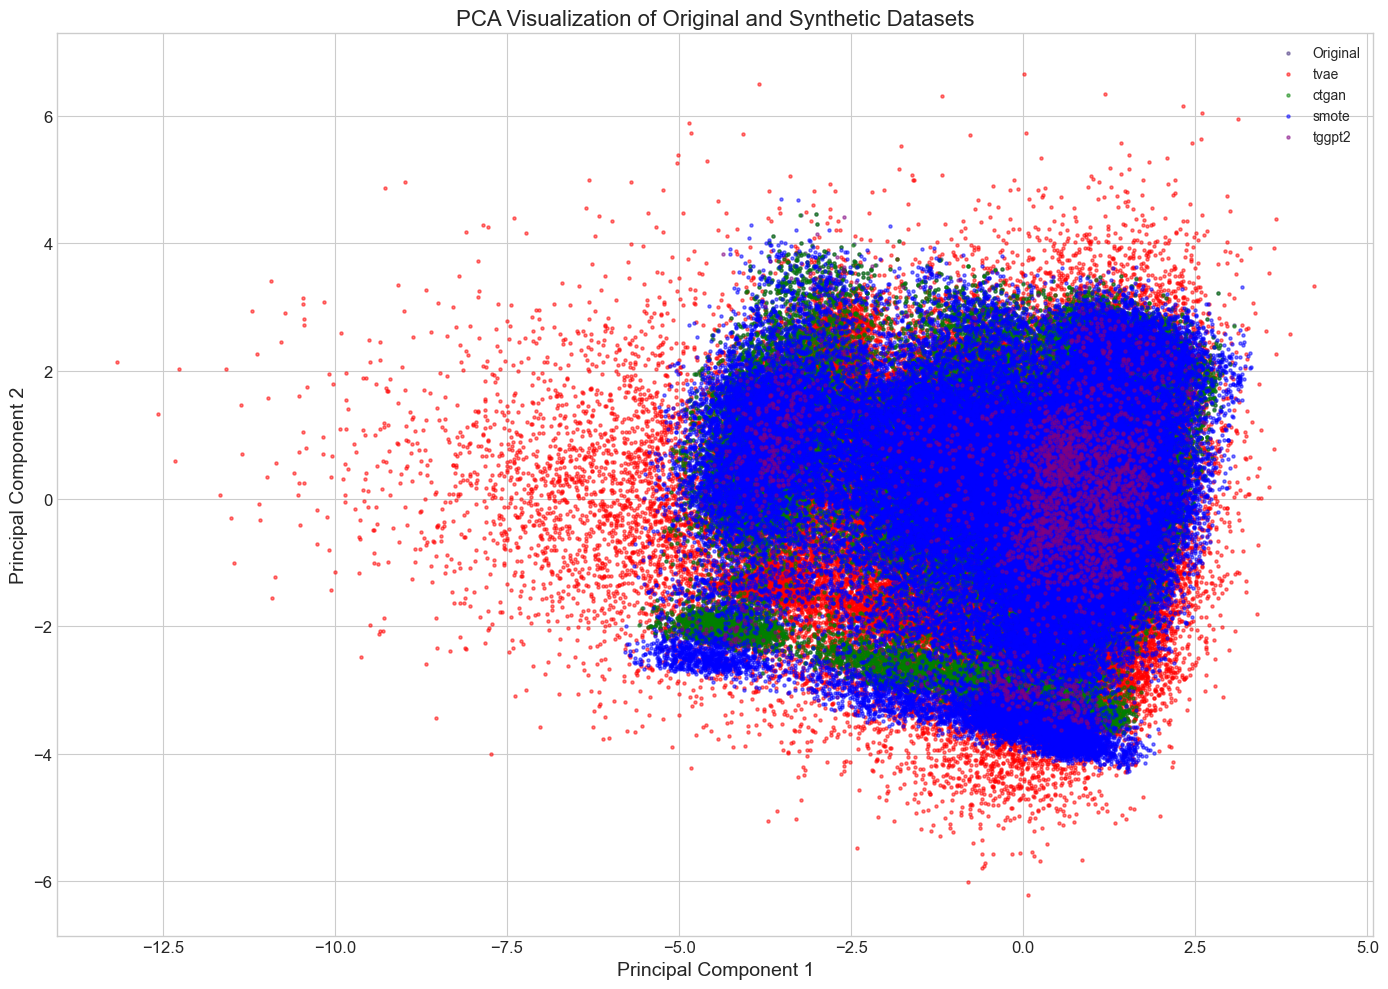

----- Overlapp SIMILARITY ANALYSIS -----


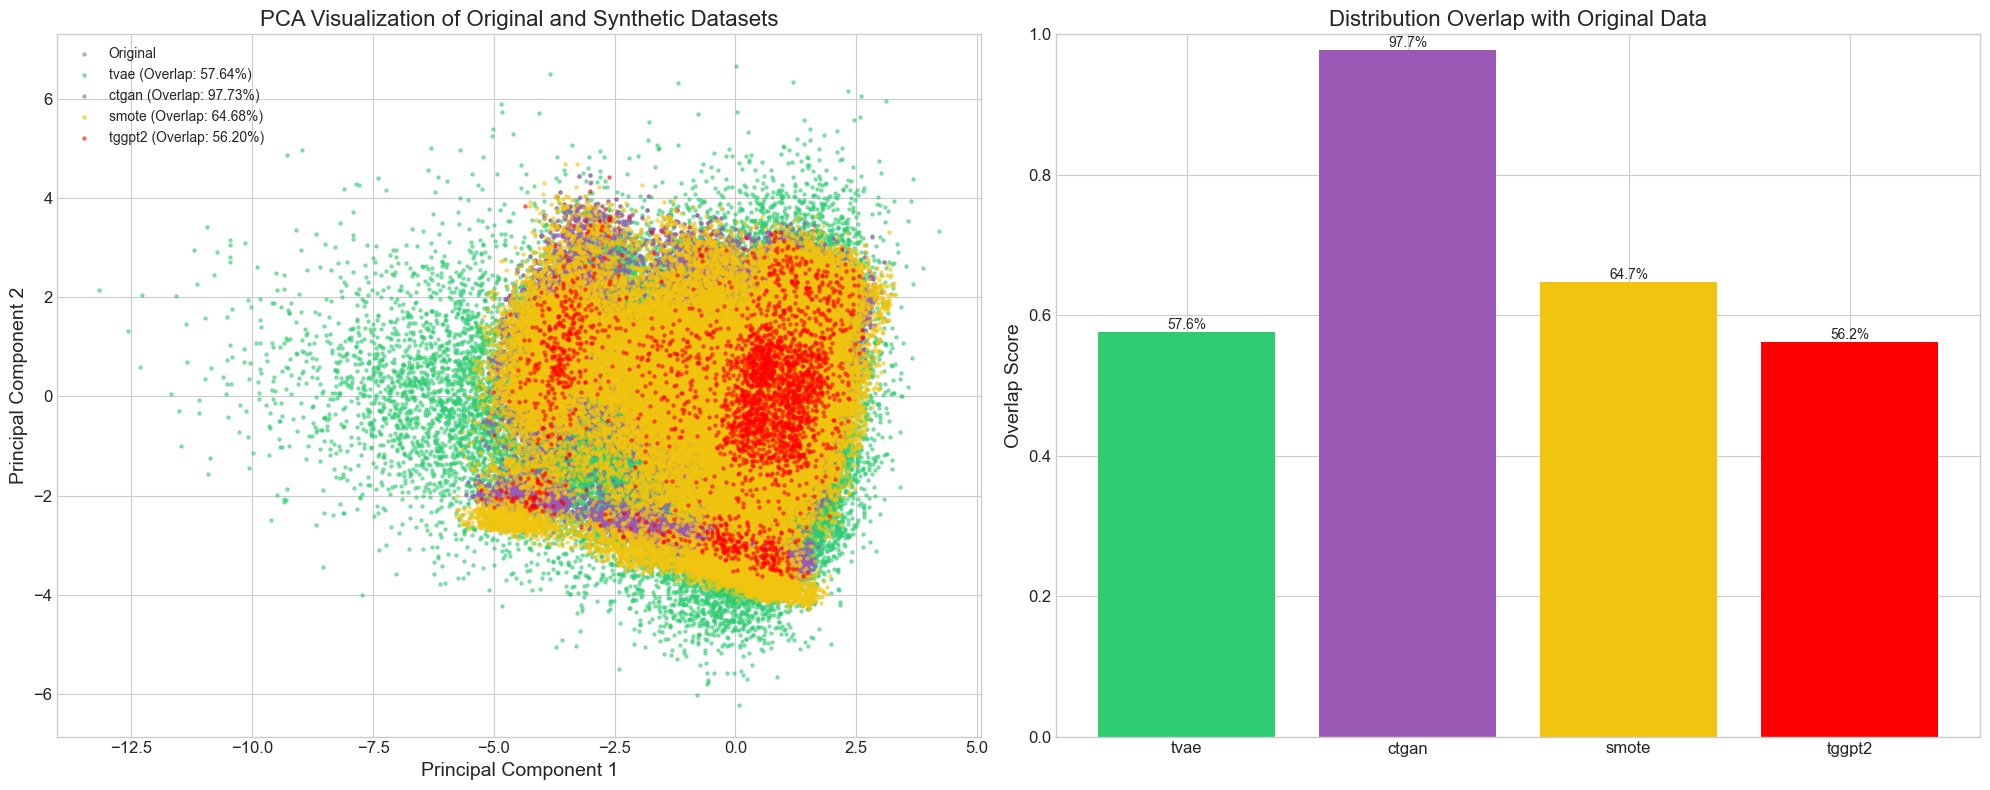


Distribution Overlap Scores:
tvae: 57.64%
ctgan: 97.73%
smote: 64.68%
tggpt2: 56.20%


NameError: name 'frobenius_norms' is not defined

In [9]:

## 5. (Optional) Feature Engineering and Similarity Analysis

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


def feature_similarity_analysis(original_df, balanced_datasets):
    """
    Analyze feature similarity between original and synthetic datasets
    """
    # Prepare numerical columns for PCA
    numerical_cols = original_df.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    
    # Scale original data
    original_scaled = scaler.fit_transform(original_df[numerical_cols].fillna(0))
    
    # Apply PCA
    pca = PCA(n_components=2)
    original_pca = pca.fit_transform(original_scaled)
    
    # Process synthetic datasets
    synthetic_pcas = {}
    for name, synthetic_df in balanced_datasets.items():
        synthetic_scaled = scaler.transform(synthetic_df[numerical_cols].fillna(0))
        synthetic_pcas[name] = pca.transform(synthetic_scaled)
    
    # Plot PCA with overlap analysis
    fig, overlap_scores = plot_pca_with_overlap(original_pca, synthetic_pcas)
    plt.show()
    
    # Print detailed overlap results
    print("\nDistribution Overlap Scores:")
    for name, score in overlap_scores.items():
        print(f"{name}: {score:.2%}")
    
    return overlap_scores

def calculate_distribution_overlap(data1, data2, bins=50):
    """
    Calculate the overlap between two 2D distributions using histogram intersection
    
    Parameters:
    -----------
    data1, data2 : numpy arrays
        2D PCA coordinates for two datasets
    bins : int
        Number of bins for 2D histogram
    
    Returns:
    --------
    float
        Overlap score between 0 and 1
    """
    # Create 2D histograms
    hist1, xedges, yedges = np.histogram2d(data1[:, 0], data1[:, 1], bins=bins)
    hist2, _, _ = np.histogram2d(data2[:, 0], data2[:, 1], bins=(xedges, yedges))
    
    # Normalize histograms
    hist1 = hist1 / hist1.sum()
    hist2 = hist2 / hist2.sum()
    
    # Calculate overlap (intersection over union)
    intersection = np.minimum(hist1, hist2).sum()
    union = np.maximum(hist1, hist2).sum()
    
    return intersection / union if union > 0 else 0

def plot_pca_with_overlap(original_pca, synthetic_pcas):
    """
    Plot PCA results with overlap scores
    """
    # Define color scheme
    color_scheme = {
        'tvae': '#2ecc71',    # green
        'ctgan': '#9b59b6',   # purple
        'smote': '#f1c40f',   # yellow
        'tggpt2': 'red'
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Scatter plot
    ax1.scatter(original_pca[:, 0], original_pca[:, 1], 
               alpha=0.5, label='Original', s=5, color='gray')
    
    # Calculate and store overlap scores
    overlap_scores = {}
    for name, pca_data in synthetic_pcas.items():
        overlap = calculate_distribution_overlap(original_pca, pca_data)
        overlap_scores[name] = overlap
        
        ax1.scatter(pca_data[:, 0], pca_data[:, 1], 
                   alpha=0.5, label=f'{name} (Overlap: {overlap:.2%})', 
                   s=5, c=color_scheme[name])
    
    ax1.set_title('PCA Visualization of Original and Synthetic Datasets')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.legend()
    ax1.grid(True)
    
    # Overlap scores bar plot
    bars = ax2.bar(overlap_scores.keys(), overlap_scores.values(),
                   color=[color_scheme[name] for name in overlap_scores.keys()])
    
    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.1%}',
                ha='center', va='bottom')
    
    ax2.set_title('Distribution Overlap with Original Data')
    ax2.set_ylabel('Overlap Score')
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    return fig, overlap_scores

# Update the PCA visualization section in feature_similarity_analysis
def feature_similarity_analysis(original_df, balanced_datasets):
    """
    ...existing code...
    """
    # Replace the existing PCA plotting code with:
    fig, overlap_scores = plot_pca_with_overlap(original_pca, synthetic_pcas)
    plt.show()
    
    # Print detailed overlap results
    print("\nDistribution Overlap Scores:")
    for name, score in overlap_scores.items():
        print(f"{name}: {score:.2%}")
    
    return frobenius_norms, overlap_scores

# Function to prepare data for PCA
def prepare_for_pca(df):
    # Get common numerical columns across all datasets
    common_num_cols = set(df.select_dtypes(include=np.number).columns)
    for synthetic_df in balanced_datasets.values():
        synthetic_num_cols = set(synthetic_df.select_dtypes(include=np.number).columns)
        common_num_cols = common_num_cols.intersection(synthetic_num_cols)
    
    # Convert to list and remove target column if present
    common_num_cols = list(common_num_cols)
    if target_col in common_num_cols:
        common_num_cols.remove(target_col)

    # Handle missing values first
    imputer = SimpleImputer(strategy='mean')
    imputed_data = imputer.fit_transform(df[common_num_cols])
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)

    return scaled_data, common_num_cols

# Run PCA on original data
original_data, num_cols = prepare_for_pca(original_df)
pca = PCA(n_components=2)
original_pca = pca.fit_transform(original_data)

# Apply the same PCA transformation to synthetic data
synthetic_pcas = {}
for name, df in balanced_datasets.items():
    synthetic_data, _ = prepare_for_pca(df)
    synthetic_pcas[name] = pca.transform(synthetic_data)

# Plot PCA results
plt.figure(figsize=(14, 10))

# Scatter plot for original data
plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.5, label='Original', s=5)

# Scatter plots for synthetic data
colors = ['red', 'green', 'blue', 'purple']
for (name, pca_data), color in zip(synthetic_pcas.items(), colors):
    plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.5, label=name, s=5, c=color)

plt.title('PCA Visualization of Original and Synthetic Datasets')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Run feature similarity analysis
print("----- Overlapp SIMILARITY ANALYSIS -----")
overlap_results = feature_similarity_analysis(original_df, balanced_datasets)

# # Run feature similarity analysis
# print("\n----- FEATURE SIMILARITY ANALYSIS -----")
# similarity_results = feature_similarity_analysis(original_df, balanced_datasets)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from catboost import CatBoost, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, mean_absolute_error, mean_squared_error, r2_score)
from tabulate import tabulate  # For nice tabular output

# Flag to control whether to attempt visualizations
ENABLE_VISUALIZATION = False  # Set to True if matplotlib is available

# Try importing visualization libraries, but don't fail if not available
if ENABLE_VISUALIZATION:
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        # Set up better styling for plots
        plt.style.use('seaborn-v0_8-whitegrid')
        sns.set_palette("colorblind")
        VISUALIZATION_AVAILABLE = True
    except ImportError:
        print("Visualization libraries not available. Only tabular output will be shown.")
        VISUALIZATION_AVAILABLE = False
else:
    VISUALIZATION_AVAILABLE = False

def prepare_data_for_modeling(df, target_col):
    """
    Prepare data for machine learning modeling with proper categorical encoding
    """
    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Get feature names
    feature_names = X.columns.tolist()
    
    # Identify categorical features
    categorical_features = [i for i, col in enumerate(feature_names) if X[col].dtype.name in ['object', 'category', 'bool']]
    
    # Convert object columns to category type
    for col in X.select_dtypes(['object']):
        X[col] = X[col].astype('category')
    
    # Get category codes for categorical columns
    for col in X.select_dtypes(['category']):
        X[col] = X[col].cat.codes

    return X, y, feature_names, categorical_features

def balance_classes_if_needed(X, y):
    """
    For binary classification, ensure both classes are present
    by duplicating samples if needed
    """
    unique_classes = np.unique(y)
    
    # If only one class is present, duplicate a few samples and change their labels
    if len(unique_classes) == 1:
        # Determine the missing class (assuming binary 0,1 classification)
        existing_class = unique_classes[0]
        missing_class = 1 - existing_class if existing_class in [0, 1] else 0
        
        # Take a few samples to duplicate
        n_samples = min(5, len(X))
        dup_indices = np.random.choice(len(X), n_samples, replace=False)
        
        # Create duplicated data with the missing class
        X_dup = X.iloc[dup_indices].copy()
        y_dup = pd.Series([missing_class] * n_samples, index=X_dup.index)
        
        # Combine with original data
        X_combined = pd.concat([X, X_dup])
        y_combined = pd.concat([y, y_dup])
        
        print(f"Added {n_samples} synthetic samples for class {missing_class} to enable training")
        
        return X_combined, y_combined
    
    return X, y

def train_and_evaluate_models(original_df, balanced_datasets, target_col):
    """
    Train XGBoost and CatBoost models with proper categorical handling and return results in tabular format
    
    Parameters:
    -----------
    original_df : pandas DataFrame
        The original dataset
    balanced_datasets : dict
        Dictionary of balanced/synthetic datasets {name: dataframe}
    target_col : str
        Name of the target column
        
    Returns:
    --------
    tuple
        (results DataFrame, is_classification flag)
    """
    # Initialize results dictionary
    results = {
        'original': {'xgboost': {}, 'catboost': {}},
    }
    for name in balanced_datasets:
        results[name] = {'xgboost': {}, 'catboost': {}}

    # Determine if classification or regression
    is_classification = original_df[target_col].dtype.name in ['object', 'category', 'bool'] or \
                       len(original_df[target_col].unique()) < 10

    # Prepare original data
    X_orig, y_orig, feature_names, categorical_features = prepare_data_for_modeling(original_df, target_col)
    
    # Get unique target values for consistent encoding
    unique_classes = None
    if is_classification:
        if y_orig.dtype.name in ['object', 'category']:
            # Store unique classes to ensure consistent encoding
            unique_classes = sorted(y_orig.unique())
            # Convert to numeric using the ordering of unique values
            y_map = {val: i for i, val in enumerate(unique_classes)}
            y_orig = y_orig.map(y_map)
        else:
            # If already numeric, get unique values for consistency check
            unique_classes = sorted(y_orig.unique())

    # Split data
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X_orig, y_orig, test_size=0.2, random_state=42, 
        stratify=y_orig if is_classification else None
    )
    
    print("\nTraining and evaluating models on original data...")

    # Define a helper function to train models to avoid code duplication
    def train_and_evaluate(model_type, X_train, y_train, X_test, y_test, is_classification, categorical_features=None):
        """Helper function to train models and evaluate them"""
        
        metrics = {}
        model = None
        
        # Ensure both classes are present for training if binary classification
        if is_classification and len(np.unique(y_train)) < len(np.unique(np.concatenate([y_train, y_test]))):
            X_train, y_train = balance_classes_if_needed(X_train, y_train)
        
        try:
            if model_type == 'xgboost':
                if is_classification:
                    # For classification
                    model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
                    # Standard fit with no extra parameters
                    model.fit(X_train, y_train)

                    # Predict and evaluate
                    y_pred = model.predict(X_test)
                    try:
                        y_pred_proba = model.predict_proba(X_test)
                    except Exception as e:
                        print(f"Warning: Could not get probability predictions: {e}")
                        y_pred_proba = None

                    # Calculate metrics
                    metrics['accuracy'] = accuracy_score(y_test, y_pred)
                    try:
                        metrics['precision'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                        metrics['recall'] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                        metrics['f1_score'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
                    except Exception as e:
                        print(f"Warning: Could not calculate some metrics: {e}")
                        metrics['precision'] = metrics['recall'] = metrics['f1_score'] = np.nan

                    # For binary classification, calculate ROC AUC
                    if len(np.unique(y_test)) == 2 and len(np.unique(y_train)) == 2 and y_pred_proba is not None:
                        try:
                            metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba[:, 1])
                        except (IndexError, ValueError) as e:
                            print(f"Warning: Could not calculate ROC AUC: {e}")
                            # Try alternative calculation if class labels aren't 0,1
                            try:
                                metrics['roc_auc'] = roc_auc_score(y_test, y_pred)
                            except Exception:
                                metrics['roc_auc'] = np.nan

                    print(f"XGBoost: Accuracy = {metrics.get('accuracy', np.nan):.4f}, F1 = {metrics.get('f1_score', np.nan):.4f}")
                    
                else:
                    # For regression
                    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
                    model.fit(X_train, y_train)

                    # Predict and evaluate
                    y_pred = model.predict(X_test)

                    # Calculate metrics
                    metrics['mae'] = mean_absolute_error(y_test, y_pred)
                    metrics['mse'] = mean_squared_error(y_test, y_pred)
                    metrics['r2_score'] = r2_score(y_test, y_pred)

                    print(f"XGBoost: MAE = {metrics['mae']:.4f}, MSE = {metrics['mse']:.4f}, R² = {metrics['r2_score']:.4f}")
                    
            elif model_type == 'catboost':
                if is_classification:
                    # For classification
                    model = CatBoost({
                        'iterations': 100,
                        'learning_rate': 0.1,
                        'random_seed': 42,
                        'loss_function': 'MultiClass' if len(np.unique(y_train)) > 2 else 'Logloss',
                        'verbose': 0
                    })

                    # Create CatBoost pool
                    train_pool = Pool(X_train, y_train, cat_features=categorical_features)
                    test_pool = Pool(X_test, y_test, cat_features=categorical_features)

                    # Train model
                    model.fit(train_pool)

                    # Predict and evaluate
                    y_pred = model.predict(test_pool, prediction_type='Class')
                    try:
                        # CatBoost uses predict method with different parameters instead of predict_proba
                        y_pred_proba = model.predict(test_pool, prediction_type='Probability')
                    except Exception as e:
                        print(f"Warning: Could not get probability predictions: {e}")
                        y_pred_proba = None

                    # Calculate metrics
                    metrics['accuracy'] = accuracy_score(y_test, y_pred)
                    try:
                        metrics['precision'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
                        metrics['recall'] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
                        metrics['f1_score'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
                    except Exception as e:
                        print(f"Warning: Could not calculate some metrics: {e}")
                        metrics['precision'] = metrics['recall'] = metrics['f1_score'] = np.nan

                    # For binary classification, calculate ROC AUC
                    if len(np.unique(y_test)) == 2 and len(np.unique(y_train)) == 2 and y_pred_proba is not None:
                        try:
                            metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba[:, 1])
                        except (IndexError, ValueError) as e:
                            print(f"Warning: Could not calculate ROC AUC: {e}")
                            try:
                                metrics['roc_auc'] = roc_auc_score(y_test, y_pred)
                            except Exception:
                                metrics['roc_auc'] = np.nan

                    print(f"CatBoost: Accuracy = {metrics.get('accuracy', np.nan):.4f}, F1 = {metrics.get('f1_score', np.nan):.4f}")
                    
                else:
                    # For regression
                    model = CatBoost({
                        'iterations': 100,
                        'learning_rate': 0.1,
                        'random_seed': 42,
                        'loss_function': 'RMSE',
                        'verbose': 0
                    })

                    # Create CatBoost pools
                    train_pool = Pool(X_train, y_train, cat_features=categorical_features)
                    test_pool = Pool(X_test, y_test, cat_features=categorical_features)

                    # Train model
                    model.fit(train_pool)

                    # Predict and evaluate
                    y_pred = model.predict(test_pool)

                    # Calculate metrics
                    metrics['mae'] = mean_absolute_error(y_test, y_pred)
                    metrics['mse'] = mean_squared_error(y_test, y_pred)
                    metrics['r2_score'] = r2_score(y_test, y_pred)

                    print(f"CatBoost: MAE = {metrics['mae']:.4f}, MSE = {metrics['mse']:.4f}, R² = {metrics['r2_score']:.4f}")
        except Exception as e:
            print(f"Error in {model_type} model training: {str(e)}")
            # Set all metrics to NaN for this model
            if is_classification:
                metrics = {
                    'accuracy': np.nan,
                    'precision': np.nan,
                    'recall': np.nan,
                    'f1_score': np.nan
                }
                if len(np.unique(np.concatenate([y_train, y_test]))) == 2:
                    metrics['roc_auc'] = np.nan
            else:
                metrics = {
                    'mae': np.nan,
                    'mse': np.nan,
                    'r2_score': np.nan
                }
                
        return metrics, model

    # Train and evaluate original dataset with both models
    original_xgb_metrics, xgb_model_orig = train_and_evaluate(
        'xgboost', X_train_orig, y_train_orig, X_test_orig, y_test_orig, is_classification
    )
    results['original']['xgboost'] = original_xgb_metrics
    
    original_cb_metrics, cb_model_orig = train_and_evaluate(
        'catboost', X_train_orig, y_train_orig, X_test_orig, y_test_orig, is_classification, categorical_features
    )
    results['original']['catboost'] = original_cb_metrics

    # Train and evaluate models on each synthetic dataset
    for name, df in balanced_datasets.items():
        print(f"\nTraining and evaluating models on {name} data...")

        try:
            # Prepare synthetic data
            X_synth, y_synth, _, _ = prepare_data_for_modeling(df, target_col)
            
            # Ensure synthetic data has the same column order as original
            if list(X_synth.columns) != list(X_orig.columns):
                # Handle the case where columns might be missing
                missing_cols = set(X_orig.columns) - set(X_synth.columns)
                if missing_cols:
                    print(f"Warning: Missing columns in {name} dataset: {missing_cols}")
                    # Add missing columns with zeros
                    for col in missing_cols:
                        X_synth[col] = 0
                
                # Reorder columns to match original
                X_synth = X_synth[X_orig.columns]
            
            # Ensure target encoding matches original
            if is_classification:
                if y_synth.dtype.name in ['object', 'category']:
                    # Use the same mapping as original data
                    if unique_classes is not None:
                        # Map using the same class encoding as original
                        y_map = {val: i for i, val in enumerate(unique_classes)}
                        y_synth = y_synth.map(y_map).fillna(0).astype(int)  # Handle unseen classes
                    else:
                        # Fallback to basic encoding
                        y_synth = pd.Categorical(y_synth).codes
                else:
                    # Handle numeric targets with potentially different values
                    # Ensure synthetic data has same classes as original
                    orig_classes = set(np.unique(y_orig))
                    synth_classes = set(np.unique(y_synth))
                    
                    # Add warning if classes don't match
                    if orig_classes != synth_classes:
                        print(f"Warning: Class mismatch between original and {name} dataset.")
                        print(f"Original classes: {orig_classes}")
                        print(f"Synthetic classes: {synth_classes}")
                        
                        # Try to balance if it's missing classes
                        if len(synth_classes) < len(orig_classes):
                            X_synth, y_synth = balance_classes_if_needed(X_synth, y_synth)
            
            # Split synthetic data into train/test sets
            X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(
                X_synth, y_synth, test_size=0.2, random_state=42, 
                stratify=y_synth if is_classification and len(np.unique(y_synth)) > 1 else None
            )

            # Train on synthetic, test on original (for utility testing)
            synthetic_xgb_metrics, _ = train_and_evaluate(
                'xgboost', X_train_synth, y_train_synth, X_test_orig, y_test_orig, is_classification
            )
            results[name]['xgboost'] = synthetic_xgb_metrics
            
            synthetic_cb_metrics, _ = train_and_evaluate(
                'catboost', X_train_synth, y_train_synth, X_test_orig, y_test_orig, 
                is_classification, categorical_features
            )
            results[name]['catboost'] = synthetic_cb_metrics
        except Exception as e:
            print(f"Error processing {name} dataset: {str(e)}")
            # Set all metrics to NaN for this synthetic dataset
            if is_classification:
                results[name]['xgboost'] = {
                    'accuracy': np.nan,
                    'precision': np.nan,
                    'recall': np.nan,
                    'f1_score': np.nan
                }
                results[name]['catboost'] = {
                    'accuracy': np.nan,
                    'precision': np.nan,
                    'recall': np.nan,
                    'f1_score': np.nan
                }
                if len(np.unique(y_orig)) == 2:
                    results[name]['xgboost']['roc_auc'] = np.nan
                    results[name]['catboost']['roc_auc'] = np.nan
            else:
                results[name]['xgboost'] = {
                    'mae': np.nan,
                    'mse': np.nan,
                    'r2_score': np.nan
                }
                results[name]['catboost'] = {
                    'mae': np.nan,
                    'mse': np.nan,
                    'r2_score': np.nan
                }

    # Convert results to a more structured format for tabular display
    return convert_results_to_dataframe(results, is_classification), is_classification

def convert_results_to_dataframe(results, is_classification):
    """
    Convert the nested results dictionary to a pandas DataFrame for easy display
    """
    if is_classification:
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        # Check if any model has roc_auc
        has_roc_auc = any('roc_auc' in results[dataset][model] 
                           for dataset in results 
                           for model in results[dataset])
        if has_roc_auc:
            metrics.append('roc_auc')
    else:
        metrics = ['mae', 'mse', 'r2_score']
    
    # Prepare data for the DataFrame
    data = []
    
    for dataset_name in results:
        for model_name in results[dataset_name]:
            row = {
                'dataset': dataset_name,
                'model': model_name
            }
            for metric in metrics:
                if metric in results[dataset_name][model_name]:
                    row[metric] = results[dataset_name][model_name][metric]
                else:
                    row[metric] = np.nan
            data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Sort by dataset and model
    df = df.sort_values(['dataset', 'model'])
    
    return df

def display_results_table(results_df, is_classification):
    """
    Display results in a nicely formatted table
    """
    # Format metrics based on task type
    if is_classification:
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        if 'roc_auc' in results_df.columns:
            metrics.append('roc_auc')
        task_type = "Classification"
    else:
        metrics = ['mae', 'mse', 'r2_score']
        task_type = "Regression"
    
    # Round numeric columns
    for col in metrics:
        if col in results_df.columns:
            results_df[col] = results_df[col].round(4)
    
    # Print table
    print(f"\n{task_type} Model Performance Comparison:")
    print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))
    
    # Also create pivot tables for better comparison
    for metric in metrics:
        if metric in results_df.columns:
            pivot = results_df.pivot(index='dataset', columns='model', values=metric)
            print(f"\n{metric.upper()} Comparison:")
            print(tabulate(pivot, headers='keys', tablefmt='pretty'))
    
    return metrics

def plot_results(results_df, is_classification):
    """
    Plot visualization for each metric if visualization is available
    """
    if not VISUALIZATION_AVAILABLE:
        print("\nSkipping visualizations - matplotlib not available")
        return
    
    try:
        if is_classification:
            metrics = ['accuracy', 'precision', 'recall', 'f1_score']
            if 'roc_auc' in results_df.columns:
                metrics.append('roc_auc')
            metric_titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
            if 'roc_auc' in metrics:
                metric_titles.append('ROC AUC')
            task_type = "Classification"
        else:
            metrics = ['mae', 'mse', 'r2_score']
            metric_titles = ['Mean Absolute Error', 'Mean Squared Error', 'R² Score']
            task_type = "Regression"
        
        # Create a bar plot for each metric
        for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
            plt.figure(figsize=(10, 6))  # Fixed figure size for compatibility
            
            # Create pivot for easier plotting
            pivot_df = results_df.pivot(index='dataset', columns='model', values=metric)
            
            # Basic bar plot using matplotlib directly to avoid pandas backend issues
            datasets = pivot_df.index
            x = np.arange(len(datasets))
            width = 0.35
            models = pivot_df.columns
            
            # Create bars for each model
            for j, model in enumerate(models):
                values = pivot_df[model].values
                plt.bar(x + (j - len(models)/2 + 0.5) * width, values, width, label=model)
                
                # Add value labels on bars
                for k, v in enumerate(values):
                    if not np.isnan(v):
                        plt.text(x[k] + (j - len(models)/2 + 0.5) * width, 
                                v + 0.01, f'{v:.4f}', 
                                ha='center', va='bottom', fontsize=9)
            
            # Customize plot
            plt.title(f'{title} Comparison Across Datasets')
            plt.ylabel(title)
            plt.xlabel('Dataset')
            plt.xticks(x, datasets)
            plt.legend(title='Model')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        print("Continuing with tabular output only")

def run_utility_testing(original_df, balanced_datasets, target_col):
    """
    Run the utility testing, display results in tabular format, and attempt visualizations if enabled
    """
    print("\n----- UTILITY TESTING -----")
    
    try:
        results_df, is_classification = train_and_evaluate_models(
            original_df, balanced_datasets, target_col
        )
        
        # Display results in tabular format
        metrics = display_results_table(results_df, is_classification)
        
        # Attempt visualizations only if enabled and available
        if ENABLE_VISUALIZATION:
            plot_results(results_df, is_classification)
        
        return results_df, is_classification
    except Exception as e:
        print(f"Error in utility testing: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# Example usage
run_utility_testing(original_df, balanced_datasets, target_col)


----- UTILITY TESTING -----

Training and evaluating models on original data...
XGBoost: Accuracy = 0.9843, F1 = 0.9766
CatBoost: Accuracy = 0.9843, F1 = 0.9766

Training and evaluating models on tvae data...
XGBoost: Accuracy = 0.9842, F1 = 0.9765
CatBoost: Accuracy = 0.9843, F1 = 0.9766

Training and evaluating models on ctgan data...
XGBoost: Accuracy = 0.9851, F1 = 0.9797
CatBoost: Accuracy = 0.9907, F1 = 0.9900

Training and evaluating models on smote data...
XGBoost: Accuracy = 0.9746, F1 = 0.9736
CatBoost: Accuracy = 0.9710, F1 = 0.9714

Training and evaluating models on gpt2 data...
XGBoost: Accuracy = 0.0158, F1 = 0.0006
CatBoost: Accuracy = 0.0157, F1 = 0.0005

Training and evaluating models on tggpt2 data...
XGBoost: Accuracy = 0.9843, F1 = 0.9765
CatBoost: Accuracy = 0.9843, F1 = 0.9765

Classification Model Performance Comparison:
+----------+----------+----------+-----------+--------+----------+---------+
| dataset  |  model   | accuracy | precision | recall | f1_score |

(     dataset     model  accuracy  precision  recall  f1_score  roc_auc
 5      ctgan  catboost    0.9907     0.9898  0.9907    0.9900   0.9714
 4      ctgan   xgboost    0.9851     0.9809  0.9851    0.9797   0.9081
 9       gpt2  catboost    0.0157     0.0002  0.0157    0.0005   0.5672
 8       gpt2   xgboost    0.0158     0.9845  0.0158    0.0006   0.4895
 1   original  catboost    0.9844     0.9846  0.9844    0.9766   0.7900
 0   original   xgboost    0.9843     0.9767  0.9843    0.9766   0.7717
 7      smote  catboost    0.9710     0.9717  0.9710    0.9714   0.7512
 6      smote   xgboost    0.9746     0.9726  0.9746    0.9736   0.8063
 11    tggpt2  catboost    0.9843     0.9688  0.9843    0.9765   0.5168
 10    tggpt2   xgboost    0.9843     0.9688  0.9843    0.9765   0.4918
 3       tvae  catboost    0.9843     0.9767  0.9843    0.9766   0.7052
 2       tvae   xgboost    0.9842     0.9688  0.9842    0.9765   0.5201,
 True)


----- FEATURE IMPORTANCE ANALYSIS -----


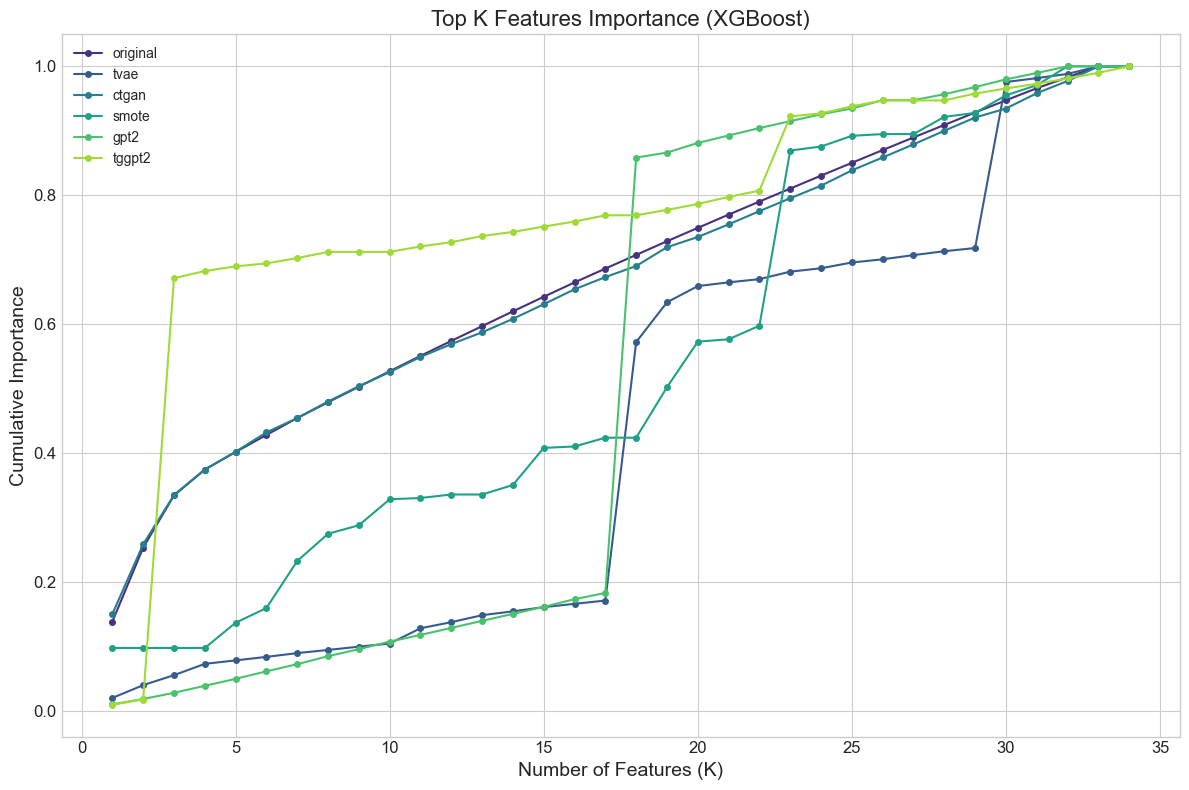

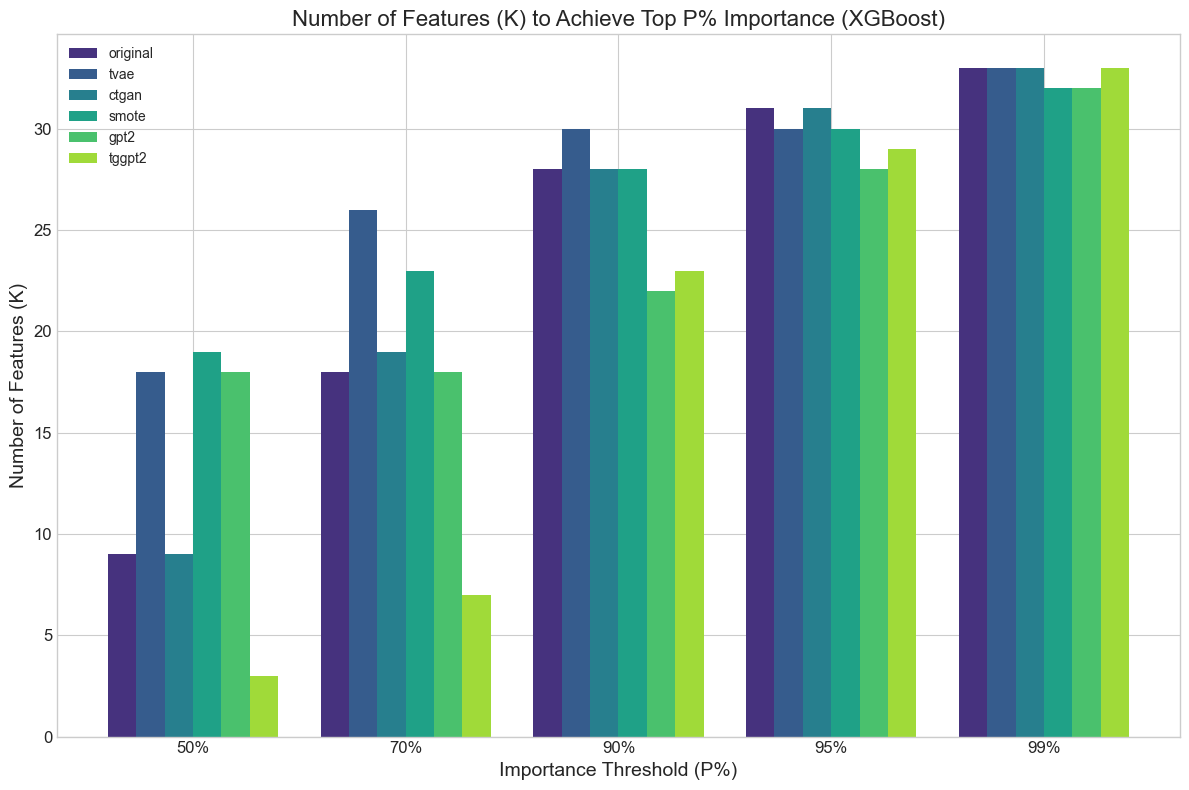

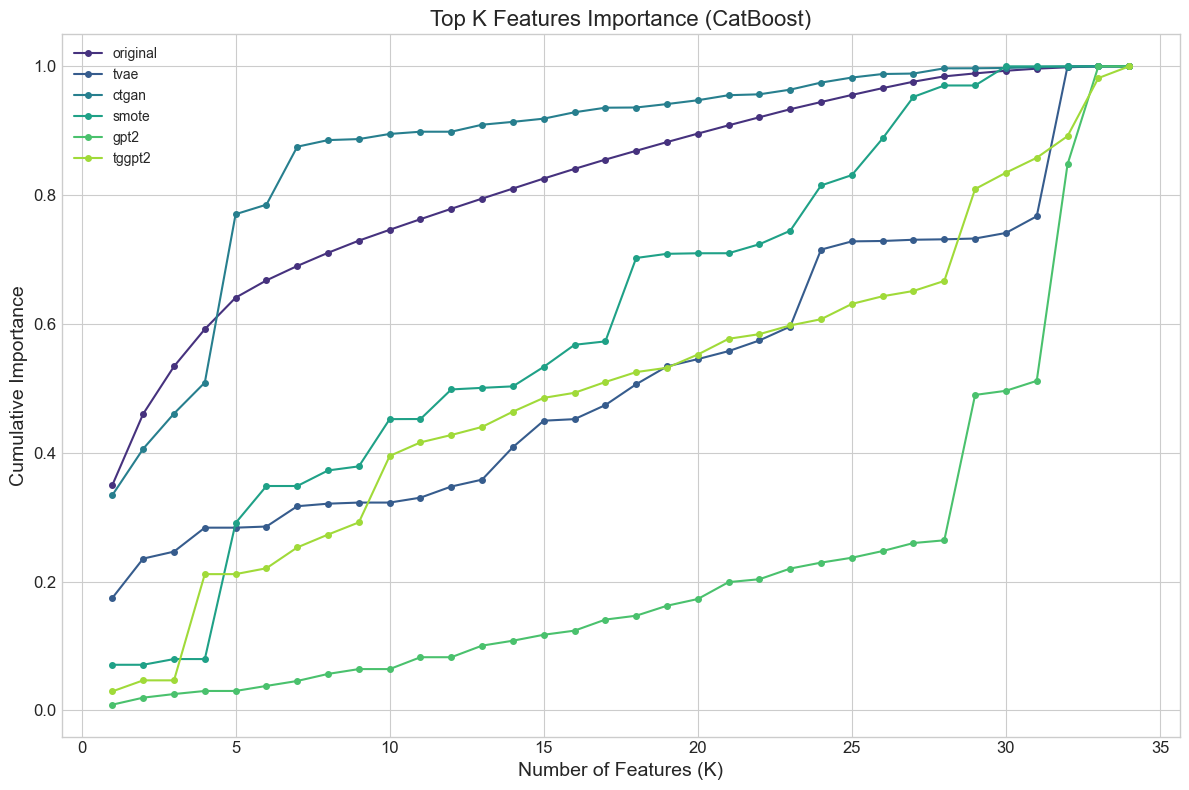

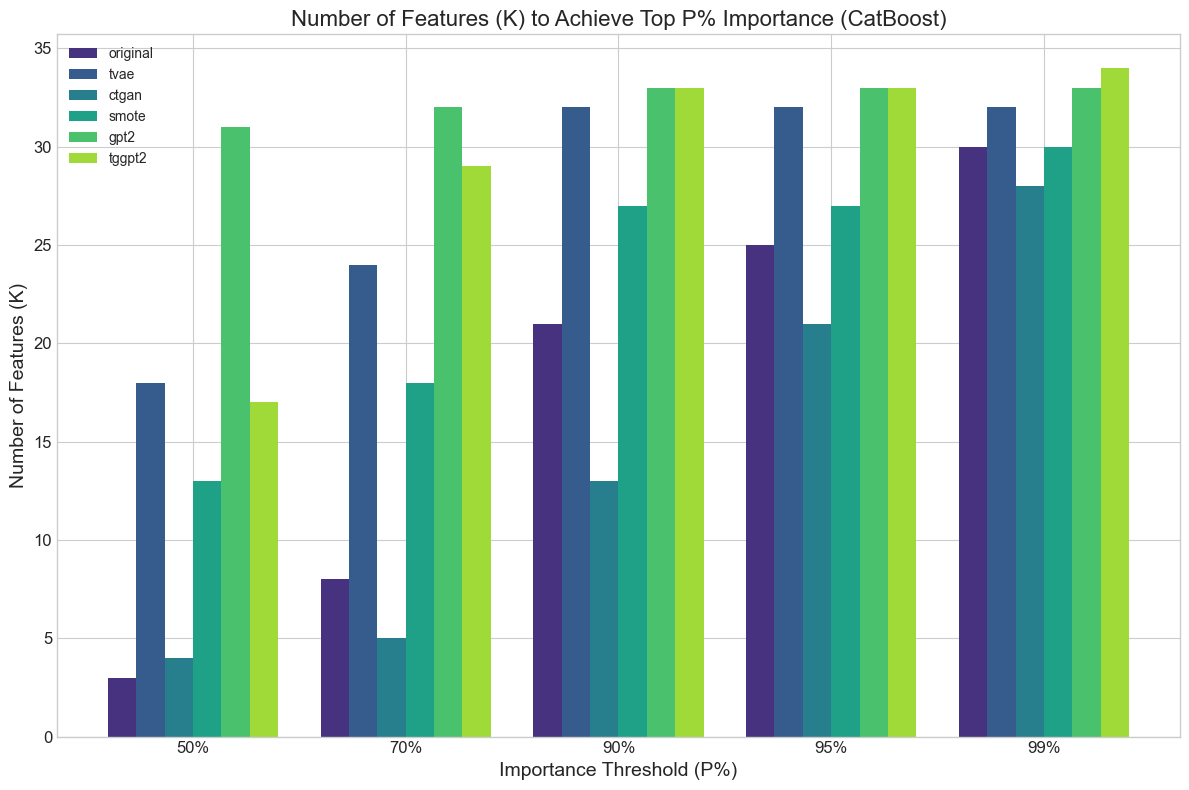

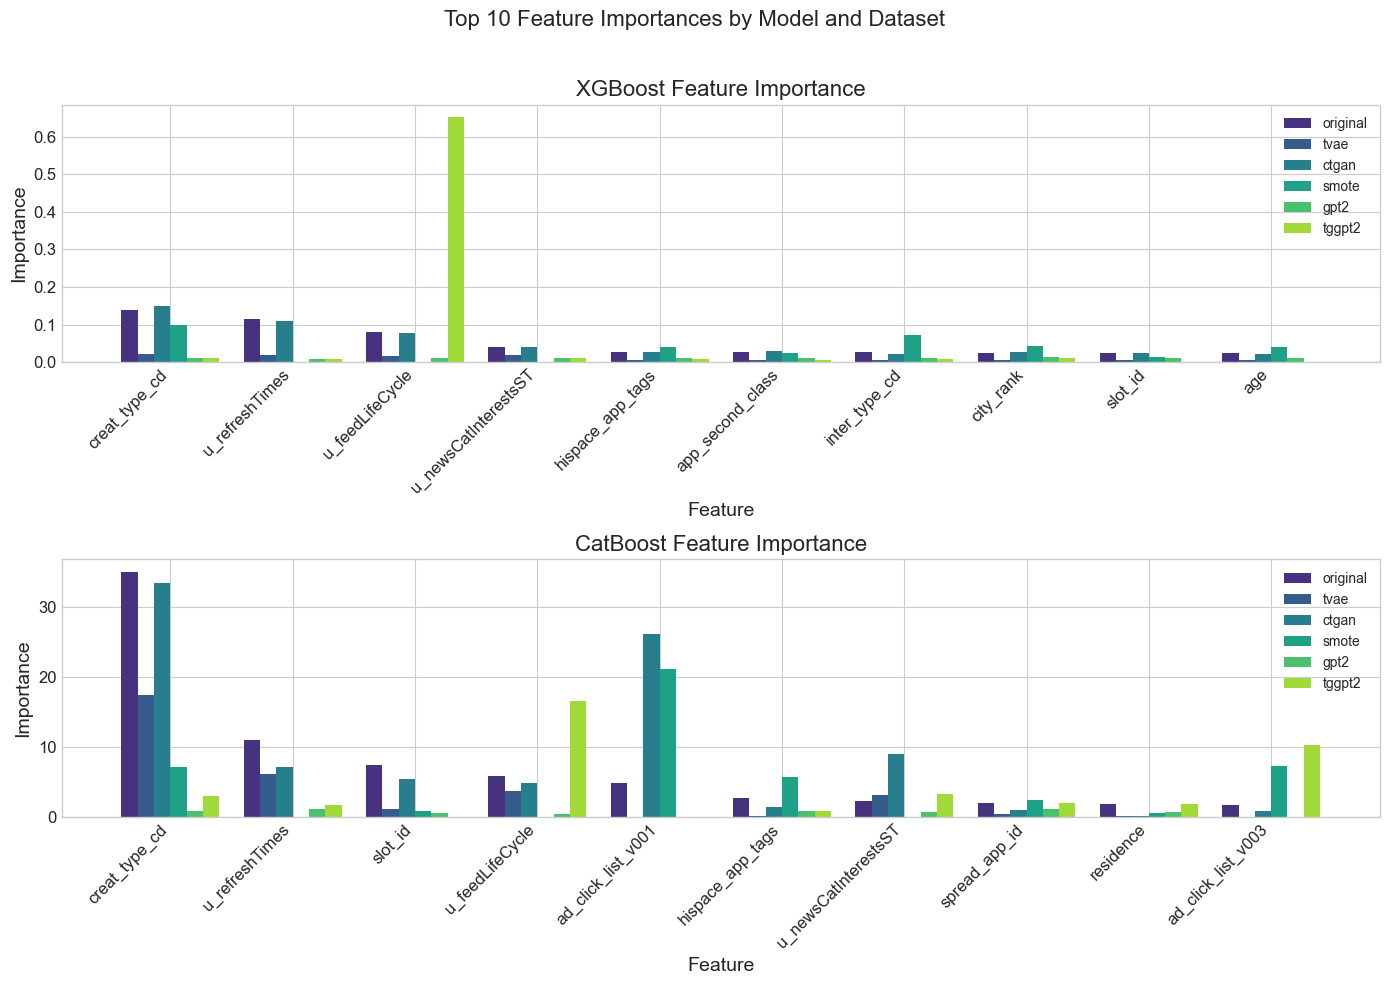

In [ ]:

## 7. Feature Importance and Top K/P Analysis

def analyze_feature_importance(original_df, balanced_datasets, target_col, feature_names, is_classification):
    """
    Analyze feature importance and create Top K/P plots

    Parameters:
    -----------
    original_df : pandas DataFrame
        The original dataset
    balanced_datasets : dict
        Dictionary of balanced synthetic datasets
    target_col : str
        Name of the target column
    feature_names : list
        List of feature names
    is_classification : bool
        Whether this is a classification problem
    """
    # Initialize dictionaries to store feature importances
    xgb_importances = {}
    cb_importances = {}

    # Prepare original data
    X_orig, y_orig, _, categorical_features = prepare_data_for_modeling(original_df, target_col)

    # Train XGBoost on original data and get feature importances
    if is_classification:
        xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    else:
        xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

    xgb_model.fit(X_orig, y_orig)
    xgb_importances['original'] = xgb_model.feature_importances_

    # Train CatBoost on original data and get feature importances
    if is_classification:
        cb_model = CatBoost({
            'iterations': 100,
            'learning_rate': 0.1,
            'random_seed': 42,
            'loss_function': 'MultiClass' if len(np.unique(y_orig)) > 2 else 'Logloss',
            'verbose': 0
        })
    else:
        cb_model = CatBoost({
            'iterations': 100,
            'learning_rate': 0.1,
            'random_seed': 42,
            'loss_function': 'RMSE',
            'verbose': 0
        })

    # Create CatBoost pool for original data
    train_pool = Pool(X_orig, y_orig, cat_features=categorical_features)

    # Train model and get feature importances
    cb_model.fit(train_pool)
    cb_importances['original'] = cb_model.get_feature_importance()

    # Train models on each synthetic dataset and get feature importances
    for name, df in balanced_datasets.items():
        # Prepare synthetic data
        X_synth, y_synth, _, _ = prepare_data_for_modeling(df, target_col)

        # Train XGBoost and get feature importances
        if is_classification:
            xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
        else:
            xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

        xgb_model.fit(X_synth, y_synth)
        xgb_importances[name] = xgb_model.feature_importances_

        # Train CatBoost and get feature importances
        if is_classification:
            cb_model = CatBoost({
                'iterations': 100,
                'learning_rate': 0.1,
                'random_seed': 42,
                'loss_function': 'MultiClass' if len(np.unique(y_synth)) > 2 else 'Logloss',
                'verbose': 0
            })
        else:
            cb_model = CatBoost({
                'iterations': 100,
                'learning_rate': 0.1,
                'random_seed': 42,
                'loss_function': 'RMSE',
                'verbose': 0
            })

        # Create CatBoost pool for synthetic data
        train_pool = Pool(X_synth, y_synth, cat_features=categorical_features)

        # Train model and get feature importances
        cb_model.fit(train_pool)
        cb_importances[name] = cb_model.get_feature_importance()

    # Create Top K and Top P plots for XGBoost
    create_topk_topp_plots(xgb_importances, feature_names, 'XGBoost')

    # Create Top K and Top P plots for CatBoost
    create_topk_topp_plots(cb_importances, feature_names, 'CatBoost')

    # Create feature importance plots
    create_feature_importance_plots(xgb_importances, cb_importances, feature_names)

    return xgb_importances, cb_importances

def create_topk_topp_plots(importances, feature_names, model_name):
    """
    Create Top K and Top P plots

    Parameters:
    -----------
    importances : dict
        Dictionary of feature importances for each dataset
    feature_names : list
        List of feature names
    model_name : str
        Name of the model ('XGBoost' or 'CatBoost')
    """
    # Sort feature indices by importance for the original dataset
    orig_sorted_indices = np.argsort(importances['original'])[::-1]

    # Calculate cumulative importance for all datasets
    cumulative_importances = {}
    for name, importance in importances.items():
        # Sort importance values based on original dataset order
        sorted_importance = importance[orig_sorted_indices]
        # Calculate cumulative sum and normalize
        cumulative_importances[name] = np.cumsum(sorted_importance) / np.sum(sorted_importance)

    # Create Top K plot
    plt.figure(figsize=(12, 8))

    for name, cumulative in cumulative_importances.items():
        plt.plot(range(1, len(cumulative) + 1), cumulative, label=name, marker='o', markersize=4)

    plt.title(f'Top K Features Importance ({model_name})')
    plt.xlabel('Number of Features (K)')
    plt.ylabel('Cumulative Importance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Create Top P plot
    p_values = [0.5, 0.7, 0.9, 0.95, 0.99]
    k_values = {}

    for name, cumulative in cumulative_importances.items():
        k_values[name] = []
        for p in p_values:
            # Find the smallest K such that cumulative importance >= p
            k = np.argmax(cumulative >= p) + 1
            k_values[name].append(k)

    # Plot Top P
    plt.figure(figsize=(12, 8))

    x = np.arange(len(p_values))
    width = 0.8 / len(k_values)

    for i, (name, ks) in enumerate(k_values.items()):
        plt.bar(x + i * width - 0.4 + width/2, ks, width, label=name)

    plt.title(f'Number of Features (K) to Achieve Top P% Importance ({model_name})')
    plt.xlabel('Importance Threshold (P%)')
    plt.ylabel('Number of Features (K)')
    plt.xticks(x, [f'{int(p*100)}%' for p in p_values])
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

def create_feature_importance_plots(xgb_importances, cb_importances, feature_names):
    """
    Create feature importance plots

    Parameters:
    -----------
    xgb_importances : dict
        Dictionary of XGBoost feature importances for each dataset
    cb_importances : dict
        Dictionary of CatBoost feature importances for each dataset
    feature_names : list
        List of feature names
    """
    # Get top 10 features based on original dataset importance
    top_n = min(10, len(feature_names))

    # XGBoost top features
    xgb_top_indices = np.argsort(xgb_importances['original'])[::-1][:top_n]
    xgb_top_features = [feature_names[i] for i in xgb_top_indices]

    # CatBoost top features
    cb_top_indices = np.argsort(cb_importances['original'])[::-1][:top_n]
    cb_top_features = [feature_names[i] for i in cb_top_indices]

    # Create XGBoost feature importance plot
    plt.figure(figsize=(14, 10))
    plt.suptitle('Top 10 Feature Importances by Model and Dataset', fontsize=16)

    plt.subplot(2, 1, 1)
    x = np.arange(len(xgb_top_features))
    width = 0.8 / len(xgb_importances)

    for i, (name, importance) in enumerate(xgb_importances.items()):
        # Get importance values for top features
        top_importances = [importance[idx] for idx in xgb_top_indices]
        plt.bar(x + i * width - 0.4 + width/2, top_importances, width, label=name)

    plt.title('XGBoost Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(x, xgb_top_features, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, axis='y')

    # Create CatBoost feature importance plot
    plt.subplot(2, 1, 2)
    x = np.arange(len(cb_top_features))
    width = 0.8 / len(cb_importances)

    for i, (name, importance) in enumerate(cb_importances.items()):
        # Get importance values for top features
        top_importances = [importance[idx] for idx in cb_top_indices]
        plt.bar(x + i * width - 0.4 + width/2, top_importances, width, label=name)

    plt.title('CatBoost Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(x, cb_top_features, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, axis='y')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()

# Get feature names (excluding target column)
feature_names = [col for col in original_df.columns if col != target_col]

# Determine if this is a classification problem based on target variable
is_classification = original_df[target_col].dtype == 'int64' and len(original_df[target_col].unique()) <= 10

# Run feature importance analysis
print("\n----- FEATURE IMPORTANCE ANALYSIS -----")
xgb_importances, cb_importances = analyze_feature_importance(
    original_df, balanced_datasets, target_col, feature_names, is_classification
)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, ks_2samp
from tabulate import tabulate

def jensen_shannon_divergence(p, q):
    """
    Calculate Jensen-Shannon divergence between two probability distributions
    """
    # Ensure p and q are valid probability distributions
    p = np.array(p)
    q = np.array(q)
    
    # Normalize if needed
    if np.sum(p) != 1:
        p = p / np.sum(p) if np.sum(p) > 0 else np.ones_like(p) / len(p)
    if np.sum(q) != 1:
        q = q / np.sum(q) if np.sum(q) > 0 else np.ones_like(q) / len(q)
    
    # Calculate the average distribution
    m = 0.5 * (p + q)
    
    # Calculate JS divergence with a small epsilon to avoid log(0)
    epsilon = 1e-10
    m = np.maximum(m, epsilon)
    
    # Calculate JS divergence
    js_divergence = 0.5 * (entropy(p, m) + entropy(q, m))
    
    # Ensure result is finite
    if not np.isfinite(js_divergence):
        return 1.0  # Maximum divergence
    
    return js_divergence

def calculate_column_fidelity(original_data, synthetic_data, col, max_categories=20, bins=10):
    """
    Calculate fidelity metrics for a single column with safeguards
    """
    metrics = {'js_divergence': np.nan, 'ks_statistic': np.nan, 'ks_pvalue': np.nan}
    
    try:
        # Handle missing values
        orig_values = original_data[col].dropna()
        synth_values = synthetic_data[col].dropna()
        
        if len(orig_values) == 0 or len(synth_values) == 0:
            return metrics
        
        # Process based on data type
        if pd.api.types.is_numeric_dtype(orig_values):
            # Numeric data - use histogram
            orig_hist, bin_edges = np.histogram(orig_values, bins=bins, density=True)
            synth_hist, _ = np.histogram(synth_values, bins=bin_edges, density=True)
            
            # Ensure histograms sum to 1
            orig_hist = orig_hist / np.sum(orig_hist) if np.sum(orig_hist) > 0 else orig_hist
            synth_hist = synth_hist / np.sum(synth_hist) if np.sum(synth_hist) > 0 else synth_hist
            
            # Calculate JS divergence
            metrics['js_divergence'] = jensen_shannon_divergence(orig_hist, synth_hist)
            
            # Calculate KS statistic
            ks_stat, ks_pval = ks_2samp(orig_values, synth_values)
            metrics['ks_statistic'] = ks_stat
            metrics['ks_pvalue'] = ks_pval
            
        else:
            # Categorical data - use value counts
            # Limit to top categories to avoid excessive computation
            orig_counts = orig_values.value_counts(normalize=True).head(max_categories)
            synth_counts = synth_values.value_counts(normalize=True).head(max_categories)
            
            # Get union of categories
            all_cats = list(set(orig_counts.index).union(set(synth_counts.index)))
            
            # Create aligned probability arrays
            orig_probs = np.zeros(len(all_cats))
            synth_probs = np.zeros(len(all_cats))
            
            for i, cat in enumerate(all_cats):
                orig_probs[i] = orig_counts.get(cat, 0)
                synth_probs[i] = synth_counts.get(cat, 0)
            
            # Normalize
            orig_probs = orig_probs / np.sum(orig_probs) if np.sum(orig_probs) > 0 else orig_probs
            synth_probs = synth_probs / np.sum(synth_probs) if np.sum(synth_probs) > 0 else synth_probs
            
            # Calculate JS divergence
            metrics['js_divergence'] = jensen_shannon_divergence(orig_probs, synth_probs)
    
    except Exception as e:
        print(f"Error calculating fidelity for column {col}: {str(e)}")
    
    return metrics

def run_fidelity_testing(original_df, balanced_datasets, sample_columns=None, max_columns=20):
    """
    Run fidelity testing with performance safeguards
    
    Parameters:
    -----------
    original_df : DataFrame
        Original dataset
    balanced_datasets : dict
        Dictionary of synthetic datasets {name: dataframe}
    sample_columns : list
        Specific columns to analyze (if None, a sample will be chosen)
    max_columns : int
        Maximum number of columns to analyze for performance
    
    Returns:
    --------
    dict
        Dictionary of fidelity results
    """
    print("\n----- FIDELITY TESTING -----")
    
    # Initialize results
    fidelity_results = {'original': {'average_js': 0.0, 'average_ks': 0.0}}
    
    # Sample columns if needed to avoid excessive computation
    if sample_columns is None:
        # Choose a mix of numerical and categorical columns
        numerical_cols = [col for col in original_df.columns if pd.api.types.is_numeric_dtype(original_df[col])]
        categorical_cols = [col for col in original_df.columns if not pd.api.types.is_numeric_dtype(original_df[col])]
        
        # Sample columns proportionally, but ensure at least one of each type if available
        num_numerical = min(max(1, int(max_columns * len(numerical_cols) / len(original_df.columns))), len(numerical_cols))
        num_categorical = min(max(1, max_columns - num_numerical), len(categorical_cols))
        
        # Sample columns
        sampled_numerical = np.random.choice(numerical_cols, num_numerical, replace=False).tolist() if num_numerical > 0 else []
        sampled_categorical = np.random.choice(categorical_cols, num_categorical, replace=False).tolist() if num_categorical > 0 else []
        
        columns = sampled_numerical + sampled_categorical
    else:
        columns = sample_columns
    
    print(f"Analyzing {len(columns)} columns for fidelity assessment")
    
    # Analyze each synthetic dataset
    for name, synth_df in balanced_datasets.items():
        print(f"\nAnalyzing {name} dataset...")
        
        # Initialize results for this dataset
        fidelity_results[name] = {
            'column_metrics': {},
            'average_js': 0.0,
            'average_ks': 0.0
        }
        
        # Calculate metrics for each column
        js_values = []
        ks_values = []
        
        for col in columns:
            # Skip columns not in synthetic data
            if col not in synth_df.columns:
                print(f"Warning: Column {col} not found in {name} dataset")
                continue
                
            # Calculate metrics for this column
            metrics = calculate_column_fidelity(original_df, synth_df, col)
            fidelity_results[name]['column_metrics'][col] = metrics
            
            # Collect metrics for averaging
            if not np.isnan(metrics['js_divergence']):
                js_values.append(metrics['js_divergence'])
            if not np.isnan(metrics['ks_statistic']):
                ks_values.append(metrics['ks_statistic'])
        
        # Calculate average metrics
        fidelity_results[name]['average_js'] = np.mean(js_values) if len(js_values) > 0 else np.nan
        fidelity_results[name]['average_ks'] = np.mean(ks_values) if len(ks_values) > 0 else np.nan
        
        print(f"Average JS Divergence: {fidelity_results[name]['average_js']:.4f}")
        print(f"Average KS Statistic: {fidelity_results[name]['average_ks']:.4f}")
    
    # Create a summary table
    summary_data = []
    for name in fidelity_results:
        if name == 'original':
            continue
        
        row = {
            'dataset': name,
            'average_js': fidelity_results[name]['average_js'],
            'average_ks': fidelity_results[name]['average_ks'],
            'fidelity_score': 1 - fidelity_results[name]['average_js']
        }
        summary_data.append(row)
    
    # Create DataFrame and sort by fidelity score
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('fidelity_score', ascending=False)
    
    # Round for display
    summary_df = summary_df.round(4)
    
    # Display summary table
    print("\nFidelity Summary:")
    print(tabulate(summary_df, headers='keys', tablefmt='pretty', showindex=False))
    
    return fidelity_results

In [ ]:
import numpy as np
import pandas as pd
from tabulate import tabulate

def calculate_overall_scores(utility_df, fidelity_results, is_classification):
    """
    Calculate overall fidelity and utility scores and determine the winner
    Modified to work with utility testing results
    """
    # Initialize scores dictionary
    overall_scores = {}

    # For each synthetic dataset
    for name in fidelity_results.keys():
        # Skip original dataset
        if name == 'original':
            continue

        # Initialize scores for this dataset
        overall_scores[name] = {}

        # Calculate fidelity score (1 - average JS divergence)
        fidelity_score = 1 - fidelity_results[name]['average_js']
        overall_scores[name]['fidelity_score'] = fidelity_score

        # Extract utility metrics from utility_df
        try:
            # Get rows for original and synthetic datasets
            original_rows = utility_df[utility_df['dataset'] == 'original']
            synthetic_rows = utility_df[utility_df['dataset'] == name]
            
            # Calculate utility score based on task type
            if is_classification:
                # For classification, use F1 score
                if 'f1_score' in synthetic_rows.columns:
                    # Handle multiple models by averaging
                    models = synthetic_rows['model'].unique() if 'model' in synthetic_rows.columns else ['default']
                    utility_scores = []
                    
                    for model in models:
                        if 'model' in synthetic_rows.columns:
                            synth_model_row = synthetic_rows[synthetic_rows['model'] == model]
                            orig_model_row = original_rows[original_rows['model'] == model]
                        else:
                            synth_model_row = synthetic_rows
                            orig_model_row = original_rows
                        
                        if len(synth_model_row) > 0 and len(orig_model_row) > 0:
                            synth_f1 = float(synth_model_row['f1_score'].iloc[0])
                            orig_f1 = float(orig_model_row['f1_score'].iloc[0])
                            
                            if orig_f1 > 0:
                                utility_score = min(synth_f1 / orig_f1, 1.0)
                                utility_scores.append(utility_score)
                    
                    if utility_scores:
                        overall_scores[name]['utility_score'] = sum(utility_scores) / len(utility_scores)
                    else:
                        overall_scores[name]['utility_score'] = 0.0
                else:
                    # Fallback to accuracy
                    overall_scores[name]['utility_score'] = 0.0
            else:
                # For regression, use R2 score
                overall_scores[name]['utility_score'] = 0.0
                if 'r2_score' in synthetic_rows.columns:
                    models = synthetic_rows['model'].unique() if 'model' in synthetic_rows.columns else ['default']
                    utility_scores = []
                    
                    for model in models:
                        if 'model' in synthetic_rows.columns:
                            synth_model_row = synthetic_rows[synthetic_rows['model'] == model]
                            orig_model_row = original_rows[original_rows['model'] == model]
                        else:
                            synth_model_row = synthetic_rows
                            orig_model_row = original_rows
                        
                        if len(synth_model_row) > 0 and len(orig_model_row) > 0:
                            synth_r2 = float(synth_model_row['r2_score'].iloc[0])
                            orig_r2 = float(orig_model_row['r2_score'].iloc[0])
                            
                            if orig_r2 > 0 and synth_r2 > 0:
                                utility_score = min(synth_r2 / orig_r2, 1.0)
                                utility_scores.append(utility_score)
                    
                    if utility_scores:
                        overall_scores[name]['utility_score'] = sum(utility_scores) / len(utility_scores)
        except Exception as e:
            print(f"Error calculating utility score for {name}: {str(e)}")
            overall_scores[name]['utility_score'] = 0.0

        # Calculate combined score (average of fidelity and utility)
        overall_scores[name]['combined_score'] = (fidelity_score + overall_scores[name]['utility_score']) / 2

    # Determine the winner based on combined score
    if overall_scores:
        winner = max(overall_scores.items(), key=lambda x: x[1]['combined_score'])[0]
    else:
        winner = "No winner found"

    return overall_scores, winner

def display_overall_evaluation(utility_df, fidelity_results, is_classification):
    """
    Run the overall evaluation and display the results in tabular format
    """
    print("\n----- OVERALL EVALUATION AND WINNER DETERMINATION -----")
    
    try:
        # Calculate overall scores and determine the winner
        overall_scores, winner = calculate_overall_scores(utility_df, fidelity_results, is_classification)
        
        # Print overall scores
        print("\nOverall Scores:")
        for name, scores in overall_scores.items():
            print(f"{name}: Fidelity = {scores['fidelity_score']:.4f}, Utility = {scores['utility_score']:.4f}, Combined = {scores['combined_score']:.4f}")
        
        print(f"\nWinner: {winner}")
        
        # Create a comparison table with all metrics
        names = list(overall_scores.keys())
        
        # Initialize DataFrame with string index
        comparison_table = pd.DataFrame(index=names)
        
        # Add fidelity metrics
        comparison_table['Fidelity Score'] = [overall_scores[name]['fidelity_score'] for name in names]
        comparison_table['Avg JS Divergence'] = [fidelity_results[name]['average_js'] for name in names]
        comparison_table['Avg KS Statistic'] = [fidelity_results[name]['average_ks'] for name in names]
        
        # Prepare for utility metrics
        metric_columns = []
        for col in utility_df.columns:
            if col not in ['dataset', 'model'] and pd.api.types.is_numeric_dtype(utility_df[col]):
                metric_columns.append(col)
        
        # Add utility metrics from DataFrame - with careful conversion
        for name in names:
            synthetic_data = utility_df[utility_df['dataset'] == name]
            if len(synthetic_data) > 0:
                for col in metric_columns:
                    # Get model-specific data if available
                    if 'model' in synthetic_data.columns:
                        models = synthetic_data['model'].unique()
                        for model in models:
                            model_data = synthetic_data[synthetic_data['model'] == model]
                            if len(model_data) > 0 and col in model_data.columns:
                                # Create a column name with the model
                                col_name = f"{model}_{col}"
                                try:
                                    comparison_table.at[name, col_name] = float(model_data[col].iloc[0])
                                except:
                                    comparison_table.at[name, col_name] = np.nan
                    else:
                        # No model column, just get the metric
                        if col in synthetic_data.columns:
                            try:
                                comparison_table.at[name, col] = float(synthetic_data[col].iloc[0])
                            except:
                                comparison_table.at[name, col] = np.nan
        
        # Add overall scores
        comparison_table['Utility Score'] = [overall_scores[name]['utility_score'] for name in names]
        comparison_table['Combined Score'] = [overall_scores[name]['combined_score'] for name in names]
        
        # Highlight the winner
        comparison_table['Winner'] = ['✓' if name == winner else '' for name in names]
        
        # Round numeric columns - with careful checking
        for col in comparison_table.columns:
            if col != 'Winner':  # Skip non-numeric columns
                try:
                    # Try to convert to float first
                    comparison_table[col] = pd.to_numeric(comparison_table[col], errors='coerce')
                    # Then round
                    comparison_table[col] = comparison_table[col].round(4)
                except Exception as e:
                    print(f"Warning: Could not round column {col}: {str(e)}")
        
        # Display the comparison table using tabulate
        print("\nComparison Table:")
        print(tabulate(comparison_table, headers='keys', tablefmt='pretty'))
        
        # Create a text-based bar chart for combined scores
        print("\nCombined Score Comparison:")
        
        # Sort datasets by combined score
        sorted_names = sorted(names, key=lambda x: overall_scores[x]['combined_score'], reverse=True)
        max_bar_width = 50  # Maximum width of bar in characters
        
        # Print bar chart
        for name in sorted_names:
            value = overall_scores[name]['combined_score']
            
            # Calculate bar width (scaled to max_bar_width)
            bar_width = int(value * max_bar_width)
            
            # Create bar using ASCII
            bar = '█' * bar_width
            
            # Highlight winner
            if name == winner:
                name_display = f"{name} (WINNER)"
            else:
                name_display = name
                
            # Print dataset, value, and bar
            print(f"{name_display.ljust(15)} {value:.4f} {bar}")
        
        # Save the comparison table to CSV
        try:
            comparison_table.to_csv('synthetic_data_comparison.csv')
            print("\nComparison table saved to 'synthetic_data_comparison.csv'")
        except Exception as e:
            print(f"\nCould not save comparison table to CSV: {str(e)}")
        
        return comparison_table, winner
    
    except Exception as e:
        print(f"Error in overall evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None


In [ ]:
# 1. Run your CatBoost utility testing
results_df, is_classification = run_utility_testing(original_df, balanced_datasets, target_col)

# 2. Run the improved fidelity testing
fidelity_results = run_fidelity_testing(original_df, balanced_datasets)

# 3. Run the overall evaluation
comparison_table, winner = display_overall_evaluation(results_df, fidelity_results, is_classification)


----- UTILITY TESTING -----

Training and evaluating models on original data...
XGBoost: Accuracy = 0.9843, F1 = 0.9766
CatBoost: Accuracy = 0.9843, F1 = 0.9766

Training and evaluating models on tvae data...
XGBoost: Accuracy = 0.9842, F1 = 0.9765
CatBoost: Accuracy = 0.9843, F1 = 0.9766

Training and evaluating models on ctgan data...
XGBoost: Accuracy = 0.9851, F1 = 0.9797
CatBoost: Accuracy = 0.9907, F1 = 0.9900

Training and evaluating models on smote data...
XGBoost: Accuracy = 0.9746, F1 = 0.9736
CatBoost: Accuracy = 0.9710, F1 = 0.9714

Training and evaluating models on gpt2 data...
XGBoost: Accuracy = 0.0158, F1 = 0.0006
CatBoost: Accuracy = 0.0157, F1 = 0.0005

Training and evaluating models on tggpt2 data...
XGBoost: Accuracy = 0.9843, F1 = 0.9765
CatBoost: Accuracy = 0.9843, F1 = 0.9765

Classification Model Performance Comparison:
+----------+----------+----------+-----------+--------+----------+---------+
| dataset  |  model   | accuracy | precision | recall | f1_score |